(mmm_upper_funnel_causal_approach)=
# Measuring Upper-Funnel Impact with PyMC‑Marketing

This notebook is a practical, end-to-end walkthrough for quantifying the impact of **upper-funnel channels** on a downstream business outcome using **Bayesian Marketing Mix Modeling (MMM)**. We will combine a causal DAG, a transparent data-generating process, and a PyMC-Marketing implementation that respects time dynamics (adstock) and nonlinear response (saturation). The emphasis is on **causal reasoning first**, modeling second.

## What you’ll build (at a glance)

- A **PyMC-Marketing MMM** with **Geometric Adstock** and **Michaelis–Menten** saturation for the outcome.  
- A **mediator model** that links upper-funnel activity to downstream exposure.  
- A **simulation-based effect estimator** that converts “what-if” changes in the upper funnel into outcome deltas, with uncertainty.

## Why this matters

Upper-funnel signals rarely act instantaneously or directly to our target variable. Treating them as simple features in a single regression collapses mediation, ignores carryover, and obscures the operating point where marginal returns live. A causal-first MMM clarifies **where** effects originate.

## Who this is for

Analysts and data scientists who need a **defensible** way to attribute upper-funnel investments to outcomes, and who are comfortable with Bayesian inference, time-series structure, and basic causal diagrams.

By the end, you’ll have a repeatable template for answering the “eternal question” of upper-funnel measurement—not by asking MMM to do everything, but by **aligning MMM with your causal understanding of the marketing system**.

## What this notebook covers

- **Framing the problem:** Why upper-funnel measurement is hard and how naive regressions misattribute lift.  
- **Causal scaffold:** A minimal DAG that separates **drivers**, **mediators**, and **outcomes**, clarifying what the *total* effect means.  
- **Dynamic response modeling:** How **adstock** (carryover) and **saturation** (diminishing returns) shape observable performance.  
- **Two-block estimation strategy:**  
  1) A mediator block to translate upper-funnel shifts into lower-funnel impressions.  
  2) An outcome block to map those impressions into business impact.  
- **Counterfactual thinking:** Turning interventions on upper-funnel channels into predicted changes in the outcome (g-computation).  
- **Model checking:** Posterior predictive checks and sanity tests that prevent self-deception.  
- **Reporting effects:** Impulse responses, cumulative lift, and state-dependent elasticities that decision-makers can use.


## Business Challenge: Untangling Upper → Mid → Lower Funnel Effects

A consumer brand invests heavily in awareness (video, influencers, PR). Leadership sees short-term sales plateauing and asks: *“Are our upper-funnel dollars doing anything?”* Standard dashboards show weak contemporaneous relations, and channel teams argue that “it all pays back later.” We need a defensible way to quantify how **upper-funnel exposure** propagates through **mid-funnel engagement** to **lower-funnel conversions**—without relying on feelings or opinions only.

We start by sketching the world we believe we operate in: a small causal story that will guide every modeling decision that follows.

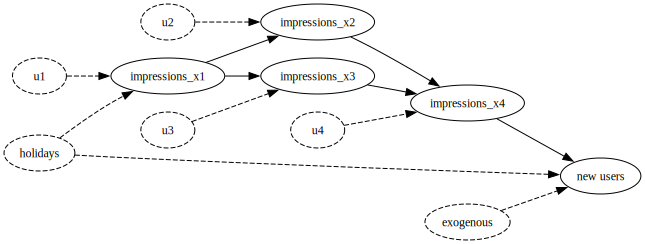

In [1]:
import graphviz

# Create the causal DAG
causal_dag = graphviz.Digraph("causal_dag")
causal_dag.attr(rankdir="LR")
causal_dag.attr("node", fontsize="12")

# Observed nodes
causal_dag.node("x1", "impressions_x1")
causal_dag.node("x2", "impressions_x2")
causal_dag.node("x3", "impressions_x3")
causal_dag.node("x4", "impressions_x4")
causal_dag.node("holidays", "holidays", shape="ellipse", style="dashed")
causal_dag.node("exogenous", "exogenous", shape="ellipse", style="dashed")
causal_dag.node("y", "new users")

# Exogenous vectors (unobserved)
causal_dag.node("u1", shape="ellipse", style="dashed")
causal_dag.node("u2", shape="ellipse", style="dashed")
causal_dag.node("u3", shape="ellipse", style="dashed")
causal_dag.node("u4", shape="ellipse", style="dashed")

# Exogenous parents
causal_dag.edge("u1", "x1", style="dashed")
causal_dag.edge("u2", "x2", style="dashed")
causal_dag.edge("u3", "x3", style="dashed")
causal_dag.edge("u4", "x4", style="dashed")

# Structural edges with coefficient labels
causal_dag.edge("x1", "x2")
causal_dag.edge("x1", "x3")
causal_dag.edge("x2", "x4")
causal_dag.edge("x3", "x4")

# add x4 to y, and holidays to y, and exogenous to y
causal_dag.edge("x4", "y")
causal_dag.edge("holidays", "y", style="dashed")
causal_dag.edge("exogenous", "y", style="dashed")

# holiday to x1
causal_dag.edge("holidays", "x1", style="dashed")

causal_dag

## The Ecosystem based on the Causal DAG

The previous DAG shows three types of effects on it.

- $X1$ **Upper funnel (Awareness impressions):**  
  Broad reach media (e.g., online video, display, influencer bursts). Drives *latent consideration* and brand memory, not immediate purchases.

- $X2$ & $X3$ **Mid funnel (Consideration touchpoints):**  
  - $X2$: Social media impressions / site landings (people start looking).  
  - $X3$: Remarketing impressions (people re-engage after a first touch).  
  These are **mediators**—they translate awareness into actionable intent.

- $X4$ **Lower funnel (High-intent exposures):**  
  Brand search. These are the **proximal drivers** of the commercial outcome.

- *U1*, *U4* **Exogenous shocks:**  
  Competitor moves, Budgets allocated to teams, or market dynamics changes can perturb each node separately.

Traditional MMMs often toss all channels into one regression and look for a global fit. For upper funnel channels, that approach can:
- **Under-credit X1** (because its effect is indirect and delayed)
- **Overfit to X4** (because it is nearest to the outcome)

## The Business Questions

- **Q1.** How much does a marginal change in *awareness* (X1) ultimately shift the outcome, via the funnel?  
- **Q2.** Where are we on the **response curve** (are we close to saturation)?  
- **Q3.** What is the expected **cumulative lift** from a planned upper-funnel flight?

## Imports

We’ll work with PyMC-Marketing for MMM components, ArviZ for diagnostics, and Pytensor to keep our simulator honest.

In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pytensor.tensor as pt
import xarray as xr
from pymc_extras.prior import Censored, Prior

from pymc_marketing.mmm import (
    GeometricAdstock,
    MichaelisMentenSaturation,
    NoAdstock,
    NoSaturation,
)
from pymc_marketing.mmm.multidimensional import MMM

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/carlostrujillo/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/multidimensional.py:216: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


## Notebook settings
To keep figures consistent and runs reproducible, we lock a seed and a plotting style.

In [3]:
SEED = 142
n_observations = 1050

warnings.filterwarnings("ignore")

# Set the style
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["axes.labelsize"] = 6
plt.rcParams["xtick.labelsize"] = 6
plt.rcParams["ytick.labelsize"] = 6

%config InlineBackend.figure_format = "retina"

## Data generation process

Based on the previous DAG, we'll start to simulate data using pytensor, during the simulation we'll need to state how the precise relationships (arrows between nodes) are represented and as consequence understand by the model. 

Here, we'll assume a fully additive model, and will understand the interactions between channels as additive models as well, by consequence the structural causal equation to build will be:

## Data generation process

Based on the previous DAG, we'll simulate data in `pytensor`. We make the relationships **additive** at each node and allow **nonlinear response** only in the final mapping from lower-funnel exposure to outcome. Time is indexed by $t=1,\dots,T$.

### Structural causal equations

Let $X_1$ (upper funnel), $X_2,X_3$ (mid funnel), $X_4$ (lower funnel), and $Y$ (business outcome). Exogenous shocks $U_j$ enter additively.

$$
\begin{aligned}
X_{1,t} &= \mu_{1,t} +  \beta_{0}\ E_t \\
X_{2,t} &= \mu_{2,t} + \beta_{12}\,X_{1,t} \\
X_{3,t} &= \mu_{3,t} + \beta_{13}\,X_{1,t} \\
X_{4,t} &= \mu_{4,t} + \beta_{24}\,X_{2,t} + \beta_{34}\,X_{3,t}
\end{aligned}
$$

- $\mu_{j,t}$ are the exogenous components of the impressions (e.g: those changes not dependent on other nodes).

### Outcome variable

Let $f(\cdot)$ denote the nonlinear response function (e.g., Geometric Adstock, Michaelis–Menten). The outcome combines transformed lower-funnel pressure with additive controls:

$$
Y_t \;=\; f\!\big(X_{4_t};\,\theta\big) \;+\; \text{Trend}_t \;+\; \text{Events}_t \;+\; \varepsilon_t,
$$

- $\text{Trend}_t$: smooth baseline evolution.
- $\text{Events}_t$: superposition of localized event basis functions.
- $\theta$: parameters of the nonlinear response function (e.g., saturation/adstock).

> **Summary:** We assume additive structure at each node, linear mediation $X_1\!\to\!(X_2,X_3)\!\to\!X_4$, dynamic carryover on $X_4$ via adstock, and a nonlinear mapping $f$ from adstocked exposure to $Y$, plus additive trend/events and noise.

Our story unfolds day by day; we create a daily timeline with a few simple calendar features.

In [4]:
min_date = pd.to_datetime("2022-01-01")
max_date = min_date + pd.Timedelta(days=n_observations)

date_range = pd.date_range(start=min_date, end=max_date, freq="D")

df = pd.DataFrame(data={"date_week": date_range}).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

Using Pytensor, we can symbolically represent the causal Directed Acyclic Graph (DAG) in an abstract way before diving into any actual computation. This framework allows us to clearly define the relationships that our data generation process must adhere to. Pytensor simplifies this task and enables us to visualize the resulting graphical model—though it’s a computational DAG rather than a causal one—helping us to confirm that the entire process aligns with our expectations.

In [5]:
# Trend
trend = pt.vector("trend")
# Noise
global_noise = pt.vector("global_noise")
# Events
pt_event_signal = pt.vector("event_signal")  # raw signal
pt_event_contributions = pt.vector("event_contributions")  # contribution to y
# Outcome
y = trend + global_noise + pt_event_contributions
y.dprint();

Add [id A]
 ├─ Add [id B]
 │  ├─ trend [id C]
 │  └─ global_noise [id D]
 └─ event_contributions [id E]


Take a quick glance at the computational graph so we don’t fool ourselves: the ingredients combine exactly as intended. Next, we write down how awareness spills into consideration and then into high‑intent exposures. These links are simple—by design—so we can focus on the causal path rather than curve fitting.

In [6]:
beta_event_x1 = pt.scalar("beta_event_x1")
impressions_x1 = pt.vector("impressions_x1") + (pt_event_signal * beta_event_x1)
beta_x1_x2 = pt.scalar("beta_x1_x2")
beta_x1_x3 = pt.scalar("beta_x1_x3")
impressions_x2 = pt.vector("impressions_x2") + (impressions_x1 * beta_x1_x2)
impressions_x3 = pt.vector("impressions_x3") + (impressions_x1 * beta_x1_x3)
beta_x2_x4 = pt.scalar("beta_x2_x4")
beta_x3_x4 = pt.scalar("beta_x3_x4")
impressions_x4 = (
    pt.vector("impressions_x4")
    + (impressions_x2 * beta_x2_x4)
    + (impressions_x3 * beta_x3_x4)
)

impressions_x4.dprint();

Add [id A]
 ├─ Add [id B]
 │  ├─ impressions_x4 [id C]
 │  └─ Mul [id D]
 │     ├─ Add [id E]
 │     │  ├─ impressions_x2 [id F]
 │     │  └─ Mul [id G]
 │     │     ├─ Add [id H]
 │     │     │  ├─ impressions_x1 [id I]
 │     │     │  └─ Mul [id J]
 │     │     │     ├─ event_signal [id K]
 │     │     │     └─ ExpandDims{axis=0} [id L]
 │     │     │        └─ beta_event_x1 [id M]
 │     │     └─ ExpandDims{axis=0} [id N]
 │     │        └─ beta_x1_x2 [id O]
 │     └─ ExpandDims{axis=0} [id P]
 │        └─ beta_x2_x4 [id Q]
 └─ Mul [id R]
    ├─ Add [id S]
    │  ├─ impressions_x3 [id T]
    │  └─ Mul [id U]
    │     ├─ Add [id H]
    │     │  └─ ···
    │     └─ ExpandDims{axis=0} [id V]
    │        └─ beta_x1_x3 [id W]
    └─ ExpandDims{axis=0} [id X]
       └─ beta_x3_x4 [id Y]


## Creating the data for our symbolic place holders.

First, we kick-off filling in the values for our event and trend variables. Then we craft a gently rising baseline, sprinkle in Gaussian event pulses, and add a whisper of noise.

In [7]:
np_trend = (np.linspace(start=0.0, stop=0.40, num=n_observations) + 0.06) ** (0.1 / 0.2)
pz_global_noise = pz.Normal(mu=0, sigma=0.005).rvs(
    size=n_observations, random_state=SEED
)

event_dates = ["24-12", "09-07"]  # List of events as month-day strings
std_devs = [25, 15]  # List of standard deviations for each event
events_coefficients = [0.080, 0.010]

signals_independent = []

# Initialize the event effect array
event_signal = np.zeros(len(date_range))
event_contributions = np.zeros(len(date_range))

# Generate event signals
for event, std_dev, event_coef in zip(
    event_dates, std_devs, events_coefficients, strict=False
):
    # Find all occurrences of the event in the date range
    event_occurrences = date_range[date_range.strftime("%d-%m") == event]

    for occurrence in event_occurrences:
        # Calculate the time difference in days
        time_diff = (date_range - occurrence).days

        # Generate the Gaussian basis for the event
        _event_signal = np.exp(-0.5 * (time_diff / std_dev) ** 2)

        # Add the event signal to the event effect
        signals_independent.append(_event_signal)
        event_signal += _event_signal

        event_contributions += _event_signal * event_coef

np_event_signal = event_signal
np_event_contributions = event_contributions

We plot the pieces before we mix them.

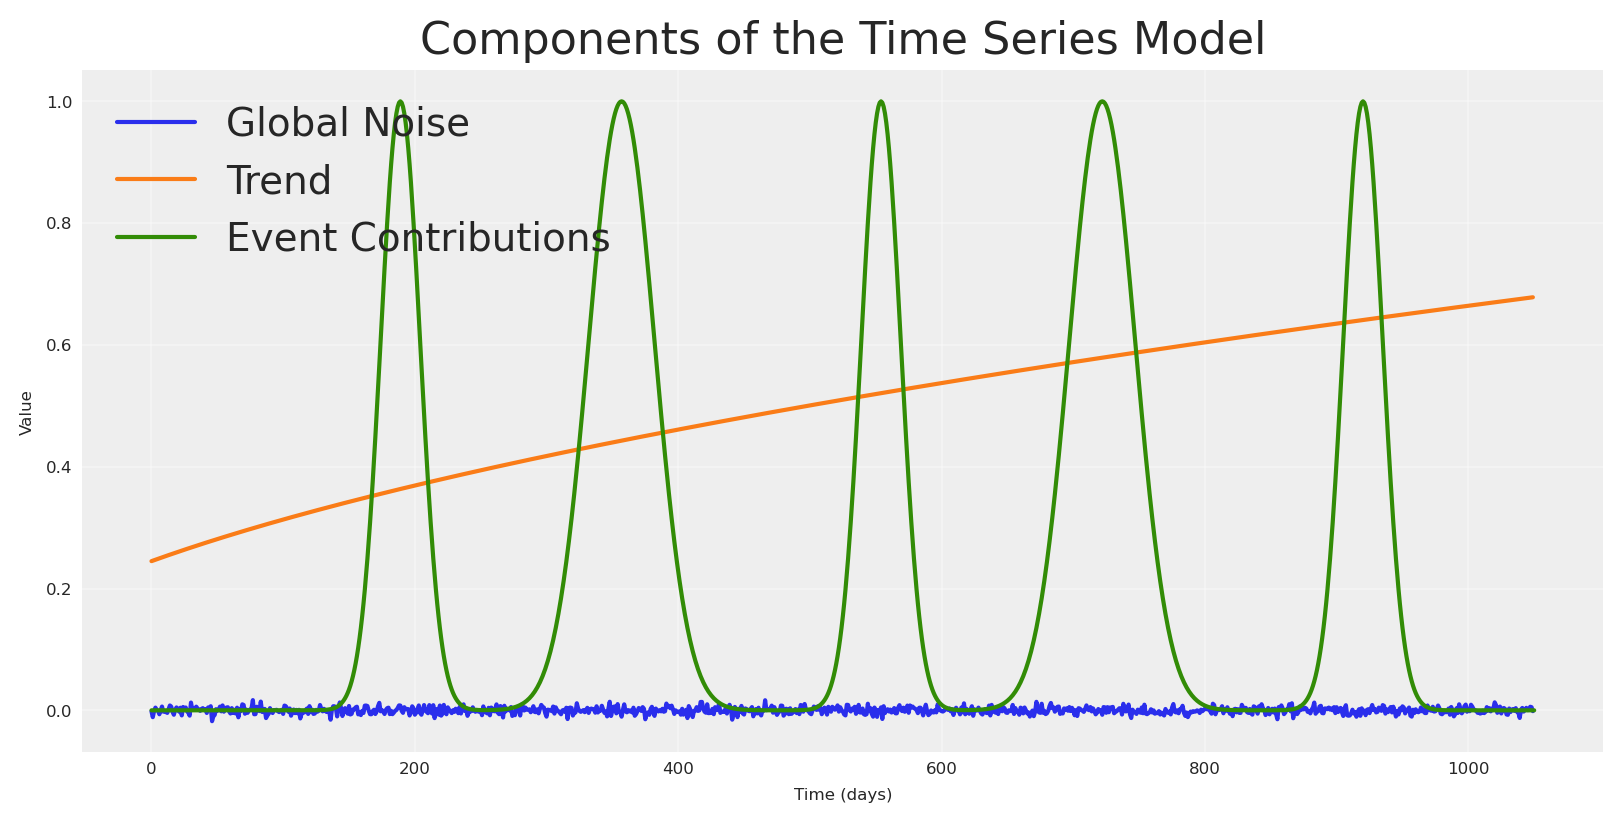

In [8]:
plt.plot(pz_global_noise, label="Global Noise")
plt.plot(np_trend, label="Trend")
plt.plot(np_event_signal, label="Event Contributions")
plt.title("Components of the Time Series Model")
plt.xlabel("Time (days)")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

We'll simulate our media variables (e.g: Impressions) as random walks. Upper, mid, and lower‑funnel exposures don’t typically jump randomly; they meander around a consistent value. A bounded random walk captures that inertia.

In [9]:
def random_walk(mu, sigma, steps, lower=None, upper=None, seed=None):
    """
    Generate a bounded random walk with specified mean and standard deviation.

    Parameters
    ----------
    mu : float
        Target mean of the random walk
    sigma : float
        Target standard deviation of the random walk
    steps : int
        Number of steps in the random walk
    lower : float, optional
        Lower bound for the random walk values
    upper : float, optional
        Upper bound for the random walk values
    seed : int, optional
        Random seed for reproducibility

    Returns
    -------
    np.ndarray
        Random walk array with specified mean, std, and bounds
    """
    # if seed none then set 123
    if seed is None:
        seed = 123
    # Create a random number generator with the given seed
    rng = np.random.RandomState(seed)

    # Start from the target mean
    walk = np.zeros(steps)
    walk[0] = mu

    # Generate the walk step by step with bounds checking
    for i in range(1, steps):
        # Generate a random increment using the seeded RNG
        increment = rng.normal(0, sigma * 0.1)  # Scale increment size

        # Propose next value
        next_val = walk[i - 1] + increment

        # Apply bounds if specified
        if lower is not None and next_val < lower:
            # Reflect off lower bound
            next_val = lower + (lower - next_val)
        if upper is not None and next_val > upper:
            # Reflect off upper bound
            next_val = upper - (next_val - upper)

        # Final bounds check (hard clipping as backup)
        if lower is not None:
            next_val = max(next_val, lower)
        if upper is not None:
            next_val = min(next_val, upper)

        walk[i] = next_val

    # Adjust to match target mean and std while respecting bounds
    current_mean = np.mean(walk)
    current_std = np.std(walk)

    if current_std > 0:
        # Center around zero, scale to target std, then shift to target mean
        walk_centered = (walk - current_mean) / current_std * sigma + mu

        # Apply bounds again after scaling
        if lower is not None:
            walk_centered = np.maximum(walk_centered, lower)
        if upper is not None:
            walk_centered = np.minimum(walk_centered, upper)

        walk = walk_centered

    return walk

We let each stream wander within bounds and take a first look at the behavior.

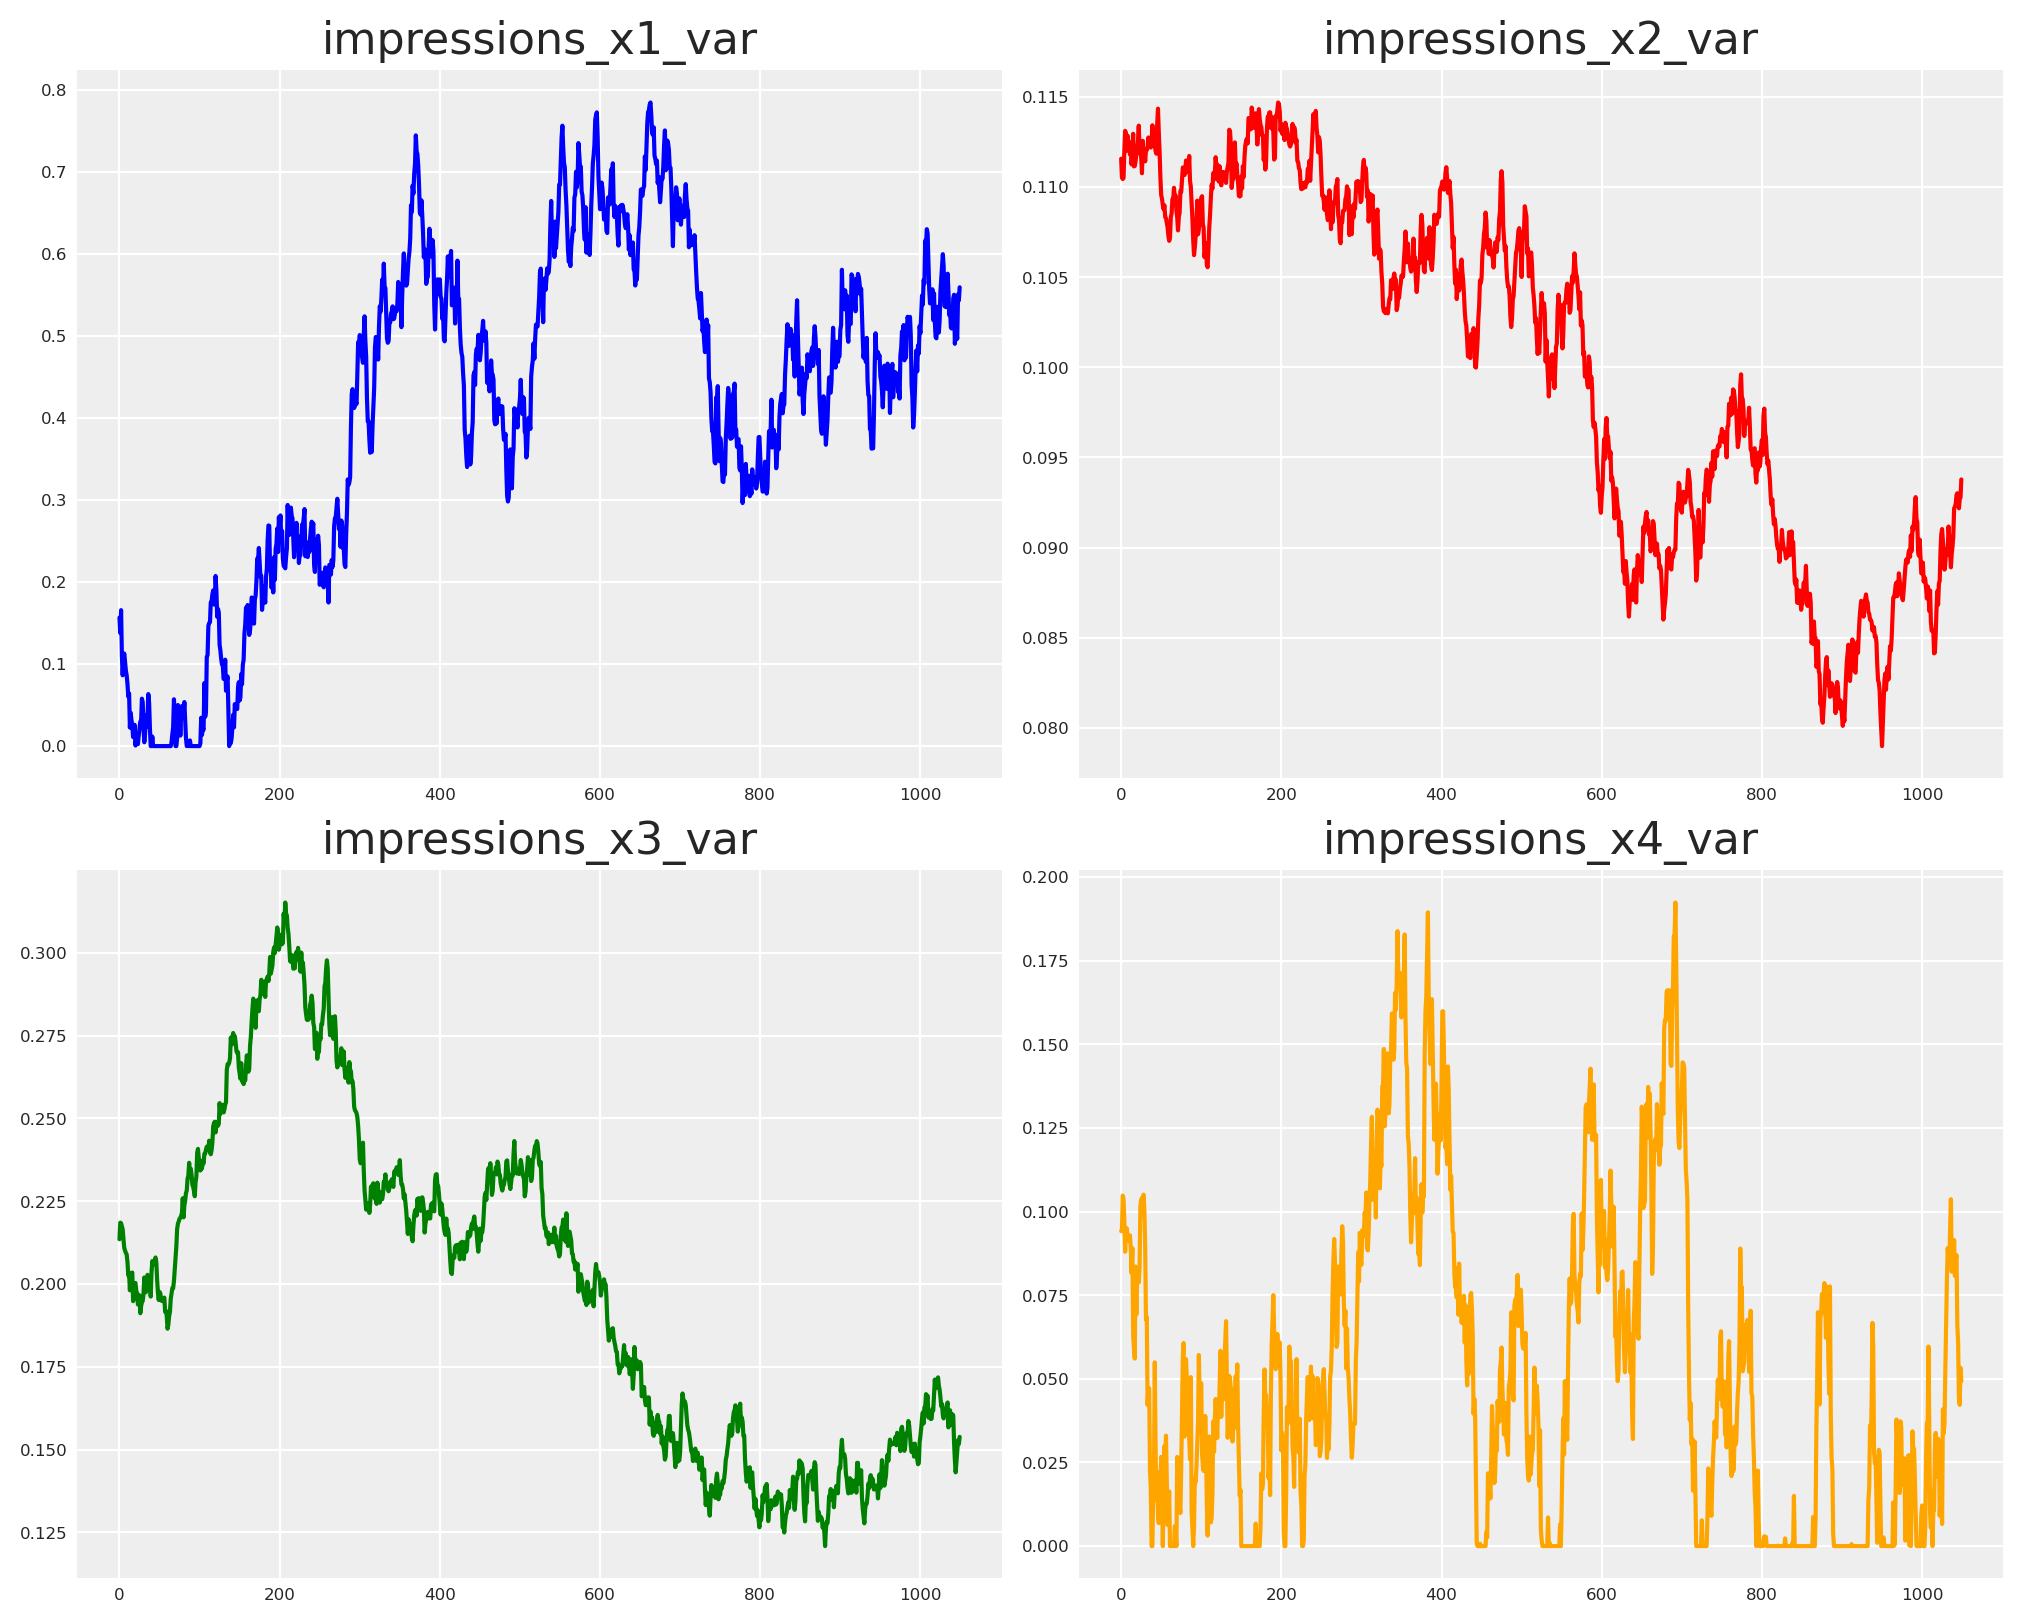

In [10]:
impressions_x1_var = random_walk(
    mu=0.41, sigma=0.21, steps=n_observations, lower=0, upper=1, seed=SEED + 1
)
impressions_x2_var = random_walk(
    mu=0.1, sigma=0.01, steps=n_observations, lower=0, upper=1, seed=SEED + 2
)
impressions_x3_var = random_walk(
    mu=0.2, sigma=0.05, steps=n_observations, lower=0, upper=1, seed=SEED - 3
)
impressions_x4_var = random_walk(
    mu=0.05, sigma=0.05, steps=n_observations, lower=0, upper=1, seed=SEED - 1
)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(impressions_x1_var, color="blue")
axs[0, 0].set_title("impressions_x1_var")
axs[0, 1].plot(impressions_x2_var, color="red")
axs[0, 1].set_title("impressions_x2_var")
axs[1, 0].plot(impressions_x3_var, color="green")
axs[1, 0].set_title("impressions_x3_var")
axs[1, 1].plot(impressions_x4_var, color="orange")
axs[1, 1].set_title("impressions_x4_var")
plt.show()

Now, we need to define the strength of the relationships, those will be the betas of every variable over the other. Doing so, we can create all missing nodes.

In [11]:
beta_x1_x2_var = 0.02
beta_x1_x3_var = 0.03
beta_x2_x4_var = 0.04
beta_x3_x4_var = 0.05
beta_event_x1_var = 0.01

impressions_x1_eval = impressions_x1.eval(
    {
        "impressions_x1": impressions_x1_var,
        "event_signal": np_event_signal[:-1],
        "beta_event_x1": beta_event_x1_var,
    }
)

impressions_x2_eval = impressions_x2.eval(
    {
        "impressions_x1": impressions_x1_var,
        "event_signal": np_event_signal[:-1],
        "beta_event_x1": beta_event_x1_var,
        "impressions_x2": impressions_x2_var,
        "beta_x1_x2": beta_x1_x2_var,
    }
)

impressions_x3_eval = impressions_x3.eval(
    {
        "impressions_x1": impressions_x1_var,
        "event_signal": np_event_signal[:-1],
        "beta_event_x1": beta_event_x1_var,
        "impressions_x3": impressions_x3_var,
        "beta_x1_x3": beta_x1_x3_var,
    }
)

impressions_x4_eval = impressions_x4.eval(
    {
        "impressions_x1": impressions_x1_var,
        "event_signal": np_event_signal[:-1],
        "beta_event_x1": beta_event_x1_var,
        "impressions_x2": impressions_x2_var,
        "impressions_x3": impressions_x3_var,
        "impressions_x4": impressions_x4_var,
        "beta_x1_x2": beta_x1_x2_var,
        "beta_x1_x3": beta_x1_x3_var,
        "beta_x2_x4": beta_x2_x4_var,
        "beta_x3_x4": beta_x3_x4_var,
    }
)

Only `X4` reaches the outcome in our story. That’s where we add memory (adstock) and diminishing returns (saturation).

Text(0.5, 1.0, 'impressions_x4_eval')

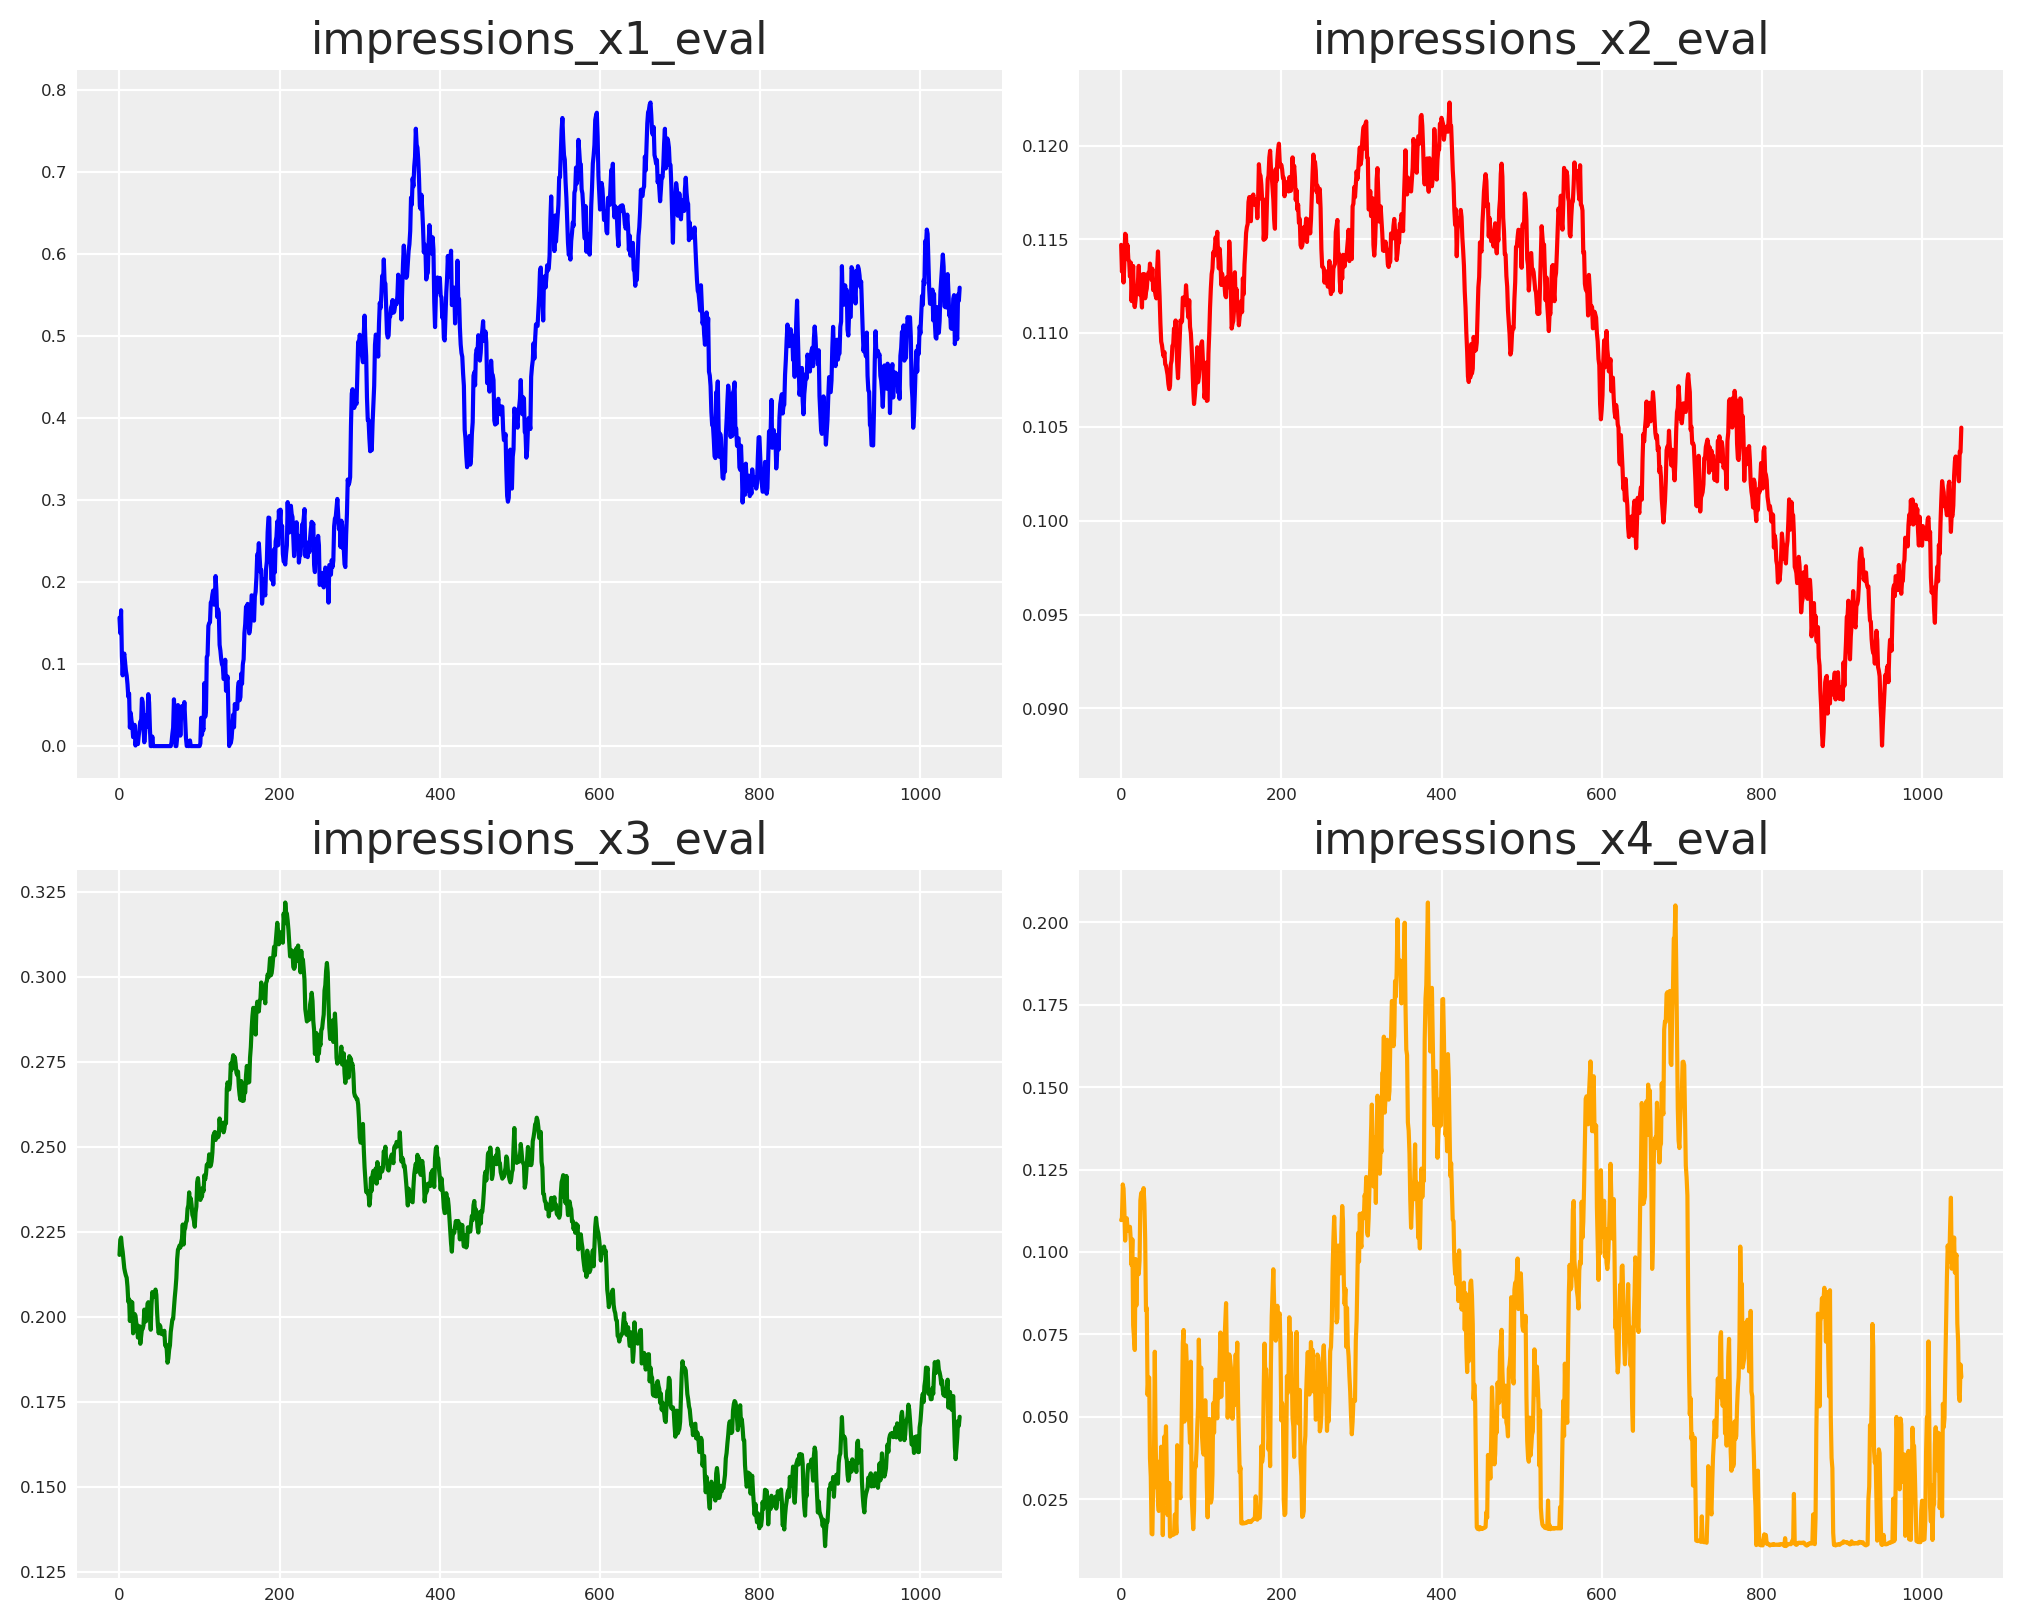

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(impressions_x1_eval, color="blue")
axs[0, 0].set_title("impressions_x1_eval")
axs[0, 1].plot(impressions_x2_eval, color="red")
axs[0, 1].set_title("impressions_x2_eval")
axs[1, 0].plot(impressions_x3_eval, color="green")
axs[1, 0].set_title("impressions_x3_eval")
axs[1, 1].plot(impressions_x4_eval, color="orange")
axs[1, 1].set_title("impressions_x4_eval")

In [13]:
# Creating forward pass for impressions
def forward_pass(x, adstock_alpha, saturation_lam, saturation_alpha):
    # return type pytensor.tensor.variable.TensorVariable
    return MichaelisMentenSaturation.function(
        MichaelisMentenSaturation,
        x=GeometricAdstock(l_max=24, normalize=False).function(
            x=x,
            alpha=adstock_alpha,
        ),
        lam=saturation_lam,
        alpha=saturation_alpha,
    )


x4_sat_lam = 0.2
x4_sat_alpha = 0.7
x4_adstock_alpha = 0.3

x4_sat_lam_scalar = pt.scalar("x4_sat_lam")
x4_sat_alpha_scalar = pt.scalar("x4_sat_alpha")
x4_adstock_alpha_scalar = pt.scalar("x4_adstock_alpha")

# Apply forward pass to impressions
impressions_x4_forward = forward_pass(
    impressions_x4, x4_adstock_alpha_scalar, x4_sat_lam_scalar, x4_sat_alpha_scalar
)

y += impressions_x4_forward
y.dprint();

Add [id A]
 ├─ Add [id B]
 │  ├─ Add [id C]
 │  │  ├─ trend [id D]
 │  │  └─ global_noise [id E]
 │  └─ event_contributions [id F]
 └─ True_div [id G]
    ├─ Mul [id H]
    │  ├─ ExpandDims{axis=0} [id I]
    │  │  └─ x4_sat_alpha [id J]
    │  └─ Blockwise{Convolve1d, (n),(k),()->(o)} [id K]
    │     ├─ Join [id L]
    │     │  ├─ -1 [id M]
    │     │  ├─ Alloc [id N]
    │     │  │  ├─ 0.0 [id O]
    │     │  │  └─ Sub [id P]
    │     │  │     ├─ Subtensor{i} [id Q]
    │     │  │     │  ├─ Shape [id R]
    │     │  │     │  │  └─ Pow [id S]
    │     │  │     │  │     ├─ ExpandDims{axis=0} [id T]
    │     │  │     │  │     │  └─ Check{0 <= alpha <= 1} [id U]
    │     │  │     │  │     │     ├─ x4_adstock_alpha [id V]
    │     │  │     │  │     │     └─ All{axes=None} [id W]
    │     │  │     │  │     │        └─ MakeVector{dtype='bool'} [id X]
    │     │  │     │  │     │           └─ All{axes=None} [id Y]
    │     │  │     │  │     │              └─ MakeVector{dtype='bool'

With everything in place, we can evaluate the target variable.

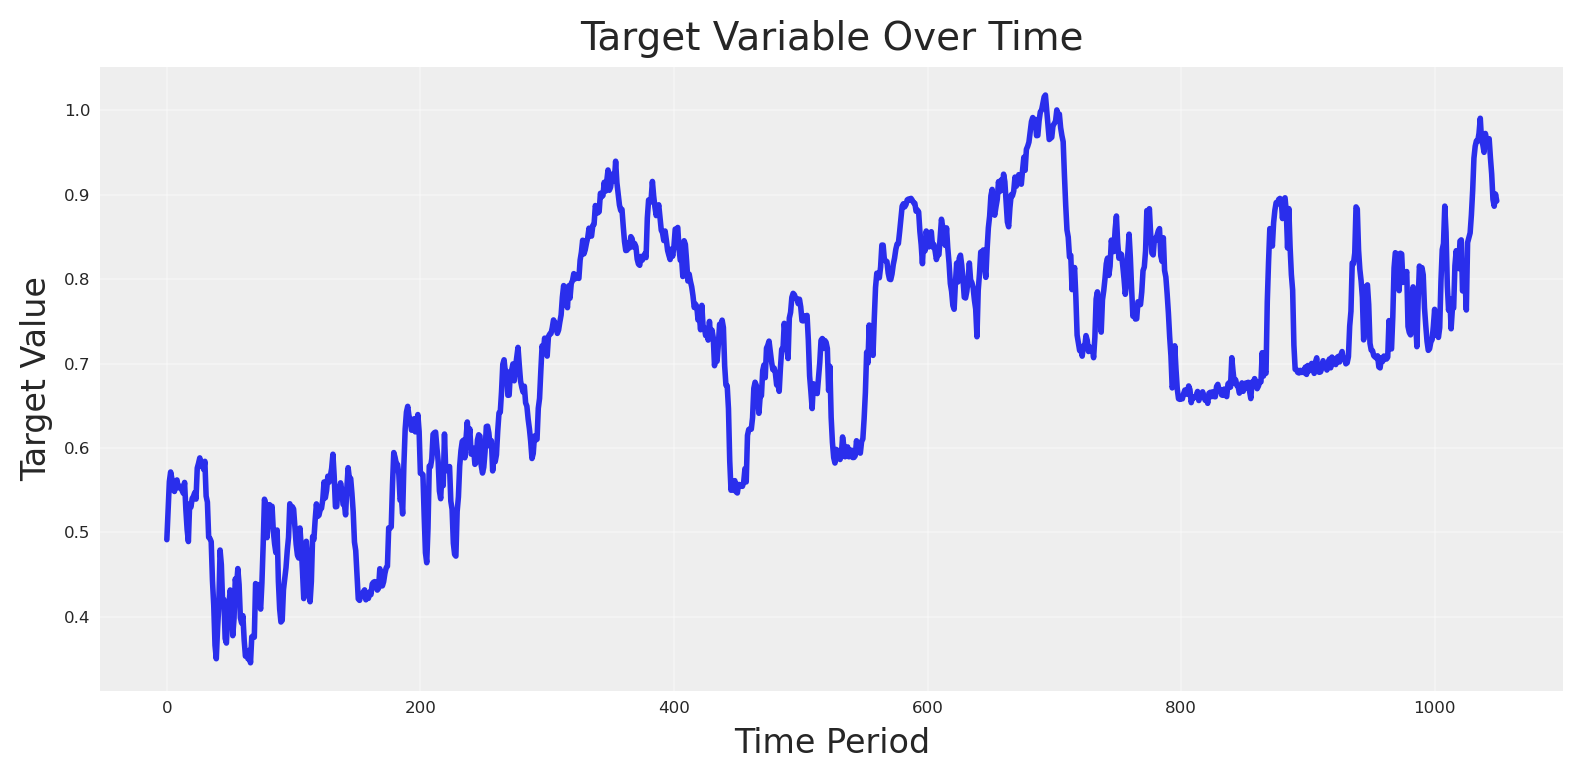

In [14]:
# Eval target_var and plot
target_var_eval = y.eval(
    {
        "impressions_x1": impressions_x1_var,
        "event_signal": np_event_signal[:-1],
        "beta_event_x1": beta_event_x1_var,
        "impressions_x2": impressions_x2_var,
        "impressions_x3": impressions_x3_var,
        "impressions_x4": impressions_x4_var,
        "beta_x1_x2": beta_x1_x2_var,
        "beta_x1_x3": beta_x1_x3_var,
        "beta_x2_x4": beta_x2_x4_var,
        "beta_x3_x4": beta_x3_x4_var,
        "x4_adstock_alpha": x4_adstock_alpha,
        "x4_sat_lam": x4_sat_lam,
        "x4_sat_alpha": x4_sat_alpha,
        "event_contributions": np_event_contributions[:-1],
        "trend": np_trend,
        "global_noise": pz_global_noise,
    }
)

plt.plot(target_var_eval, linewidth=2)
plt.title("Target Variable Over Time", fontsize=14)
plt.xlabel("Time Period", fontsize=12)
plt.ylabel("Target Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

We package our story into a single pandas dataframe with features, controls, and the outcome.

In [15]:
scaler_factor_for_target = 1
scaler_factor_for_impressions = 1
data = pd.DataFrame(
    {
        "date": date_range[:-1],
        "target_var": np.round(target_var_eval * scaler_factor_for_target, 4),
        "impressions_x1": np.round(
            impressions_x1_eval * scaler_factor_for_impressions, 4
        ),
        "impressions_x2": np.round(
            impressions_x2_eval * scaler_factor_for_impressions, 4
        ),
        "impressions_x3": np.round(
            impressions_x3_eval * scaler_factor_for_impressions, 4
        ),
        "impressions_x4": np.round(
            impressions_x4_eval * scaler_factor_for_impressions, 4
        ),
        "event_2020_09": np.round(signals_independent[0][:-1], 4),
        "event_2020_12": np.round(signals_independent[1][:-1], 4),
        "event_2021_09": np.round(signals_independent[2][:-1], 4),
        "event_2021_12": np.round(signals_independent[3][:-1], 4),
        "event_2022_09": np.round(signals_independent[4][:-1], 4),
    }
)
data["trend"] = data.index
data.head()

,date,target_var,impressions_x1,impressions_x2,impressions_x3,impressions_x4,event_2020_09,event_2020_12,event_2021_09,event_2021_12,event_2022_09,trend
0,2022-01-01,0.4913,0.1565,0.1147,0.2182,0.1097,0.0,0.0,0.0,0.0,0.0,0
1,2022-01-02,0.5267,0.1377,0.1133,0.2227,0.1104,0.0,0.0,0.0,0.0,0.0,1
2,2022-01-03,0.5603,0.1656,0.1138,0.2233,0.1205,0.0,0.0,0.0,0.0,0.0,2
3,2022-01-04,0.5715,0.1097,0.1127,0.2207,0.1192,0.0,0.0,0.0,0.0,0.0,3
4,2022-01-05,0.5635,0.0863,0.1137,0.2191,0.1127,0.0,0.0,0.0,0.0,0.0,4


## Train & Test split

We keep a holdout to test whether our counterfactual story travels beyond the training window.

In [16]:
# Split data into train and test sets
train_idx = 879

X_train = data.iloc[:train_idx].drop(columns=["target_var"])
X_test = data.iloc[train_idx:].drop(columns=["target_var"])
y_train = data.iloc[:train_idx]["target_var"]
y_test = data.iloc[train_idx:]["target_var"]

## All-in causal MMM

**What this is.** A single MMM with *all* channels modeled as if they directly affect $Y$. Each channel uses Geometric Adstock + Michaelis–Menten saturation; the likelihood is censored Normal. This strategy is very common, basically reflecting the put-it-all-into-the-blender approach.

In [17]:
control_columns = [
    "event_2020_09",
    "event_2020_12",
    "event_2021_09",
    "event_2021_12",
    "event_2022_09",
    "trend",
]

channel_columns = [
    col for col in X_train.columns if col not in control_columns and col != "date"
]

### Model configuration

We can define the model priors for every part, saturation and adstock as usual for pymc-marketing models.

In [18]:
# Building priors for adstock and saturation
adstock_priors = {
    "alpha": Prior("Beta", alpha=1, beta=1, dims="channel"),
}

adstock = GeometricAdstock(l_max=24, priors=adstock_priors)

saturation_priors = {
    "lam": Prior(
        "Gamma",
        mu=2,
        sigma=2,
        dims="channel",
    ),
    "alpha": Prior(
        "Gamma",
        mu=1,
        sigma=1,
        dims="channel",
    ),
}

saturation = MichaelisMentenSaturation(priors=saturation_priors)

Doing the same, we can define the Prior for the likelihood. We set a censored Normal likelihood (no negatives) and sampling defaults that behave well in practice.

In [19]:
# Model config
model_config = {
    "likelihood": Censored(
        Prior(
            "Normal",
            sigma=Prior("HalfNormal", sigma=1),
            dims="date",
        ),
        lower=0,
    )
}

# sampling options for PyMC
sample_kwargs = {
    "tune": 1000,
    "draws": 500,
    "chains": 4,
    "random_seed": SEED,
    "target_accept": 0.84,
}

With the config ready, we build the all‑in model and draw from its posterior.

In [20]:
allin_mmm = MMM(
    date_column="date",
    target_column="target_var",
    channel_columns=channel_columns,
    control_columns=control_columns,
    adstock=adstock,
    saturation=saturation,
    model_config=model_config,
    sampler_config=sample_kwargs,
)
allin_mmm.build_model(X_train, y_train)
allin_mmm.add_original_scale_contribution_variable(var=["channel_contribution", "y"])

### Fit model

We also generate posterior predictions to peek at in‑sample recover effects.

In [21]:
allin_mmm.fit(
    X_train,
    y_train,
)
allin_mmm.sample_posterior_predictive(X_train, extend_idata=True, combined=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_alpha, saturation_lam, gamma_control, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 263 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Sampling: [y]


Output()

<xarray.Dataset> Size: 28MB
Dimensions:           (date: 879, sample: 2000)
Coordinates:
  * date              (date) datetime64[ns] 7kB 2022-01-01 ... 2024-05-28
  * sample            (sample) object 16kB MultiIndex
  * chain             (sample) int64 16kB 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * draw              (sample) int64 16kB 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables:
    y                 (date, sample) float64 14MB 0.4799 0.4574 ... 0.8827
    y_original_scale  (date, sample) float64 14MB 0.4886 0.4657 ... 0.8988
Attributes:
    created_at:                 2025-10-03T13:34:22.288004+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

Oh! We can see the model already is getting troubles exploring the parameter space and diverging. 

Nevertheless, let's go directly to the question: **Can the model recover the true contribution if we were not spending anything at all in X1?**

We can use the `plot.contributions_over_time` and get the contribution output to find out. If the blender was enough, it would recover the true `X1` contribution. Let's check.

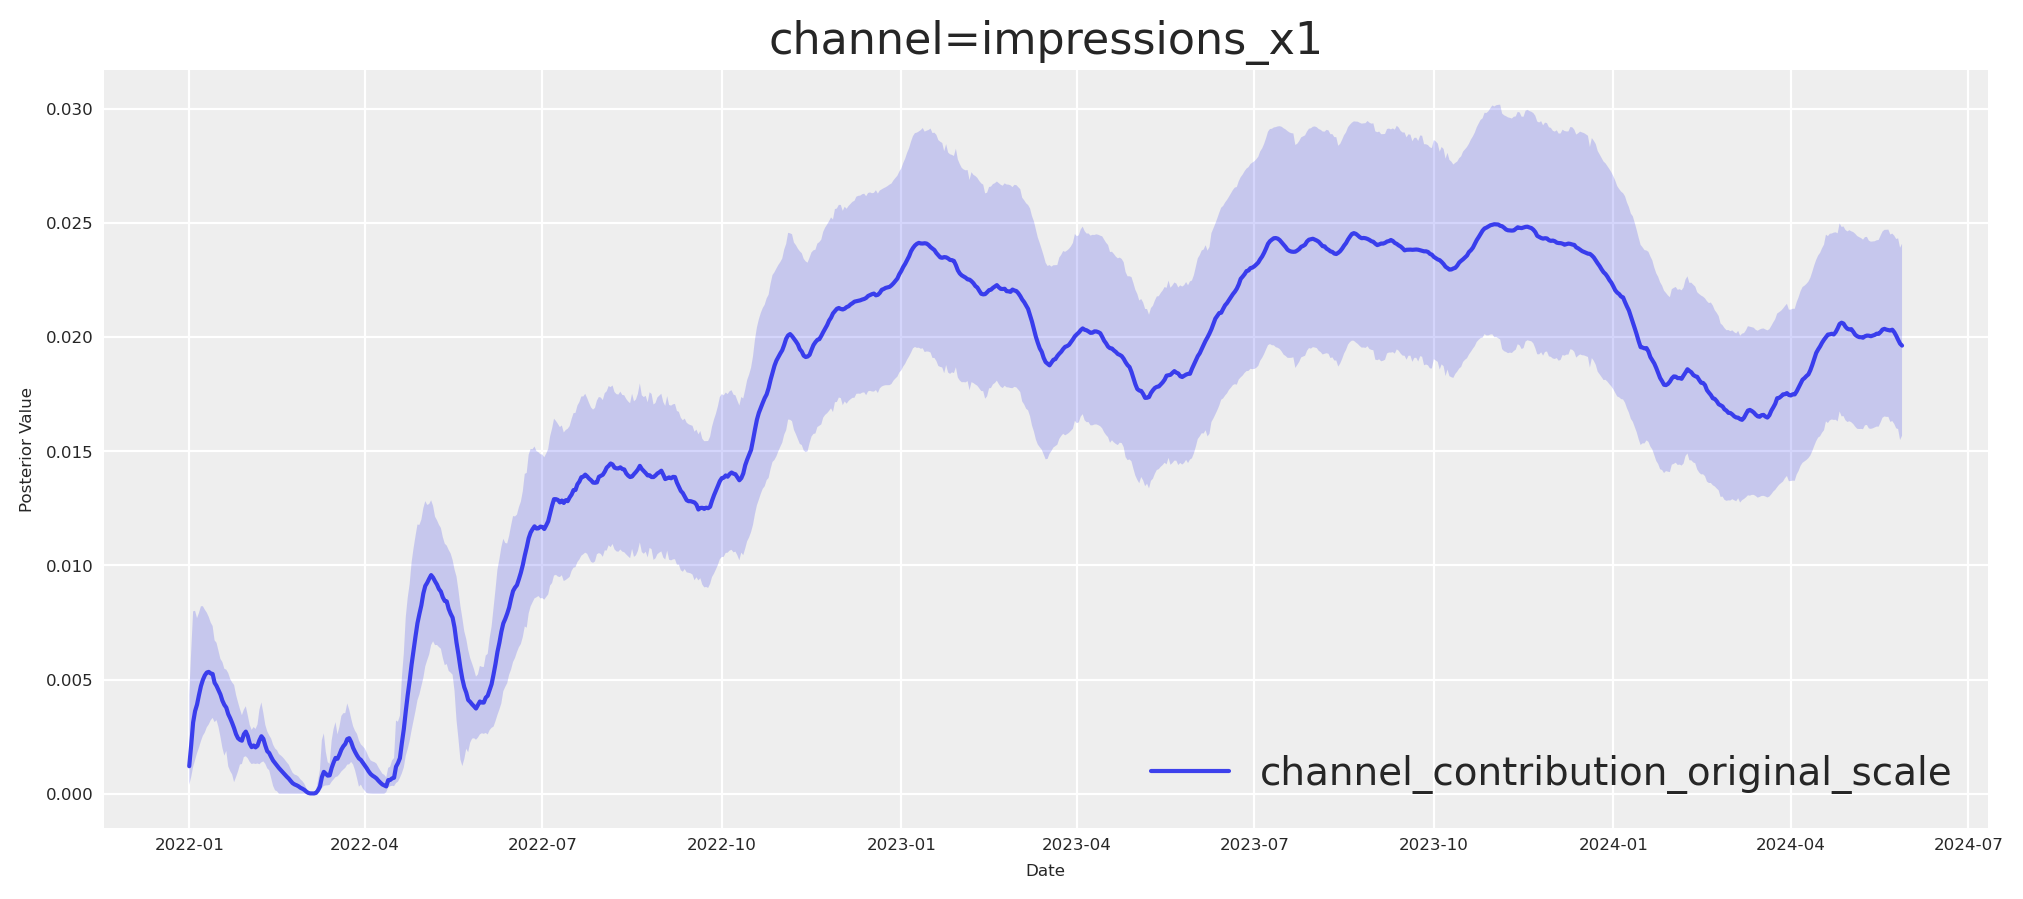

In [22]:
fig, ax = allin_mmm.plot.contributions_over_time(
    var=["channel_contribution_original_scale"], hdi_prob=0.95
)  # subplot 1 col, N rows = len(channel_columns)
# Keep only the first subplot (row 0, col 0) and hide the rest
for i in range(1, len(ax)):
    ax[i, 0].set_visible(False)
plt.show()

This is great, but we need to get the real contribution if x1 (We can compute it from our pytensor graph, assuming it was zero and taking that from target).

In [23]:
impressions_x1_zero_var = np.zeros_like(impressions_x1_var)
target_var_do_x1_eval = y.eval(
    {
        "impressions_x1": impressions_x1_zero_var,
        "event_signal": np_event_signal[:-1],
        "beta_event_x1": beta_event_x1_var,
        "impressions_x2": impressions_x2_var,
        "impressions_x3": impressions_x3_var,
        "impressions_x4": impressions_x4_var,
        "beta_x1_x2": beta_x1_x2_var,
        "beta_x1_x3": beta_x1_x3_var,
        "beta_x2_x4": beta_x2_x4_var,
        "beta_x3_x4": beta_x3_x4_var,
        "x4_adstock_alpha": x4_adstock_alpha,
        "x4_sat_lam": x4_sat_lam,
        "x4_sat_alpha": x4_sat_alpha,
        "event_contributions": np_event_contributions[:-1],
        "trend": np_trend,
        "global_noise": pz_global_noise,
    }
)

x1_real_contribution = (
    target_var_eval - target_var_do_x1_eval
) * scaler_factor_for_target

Now that we have both, we can compare.

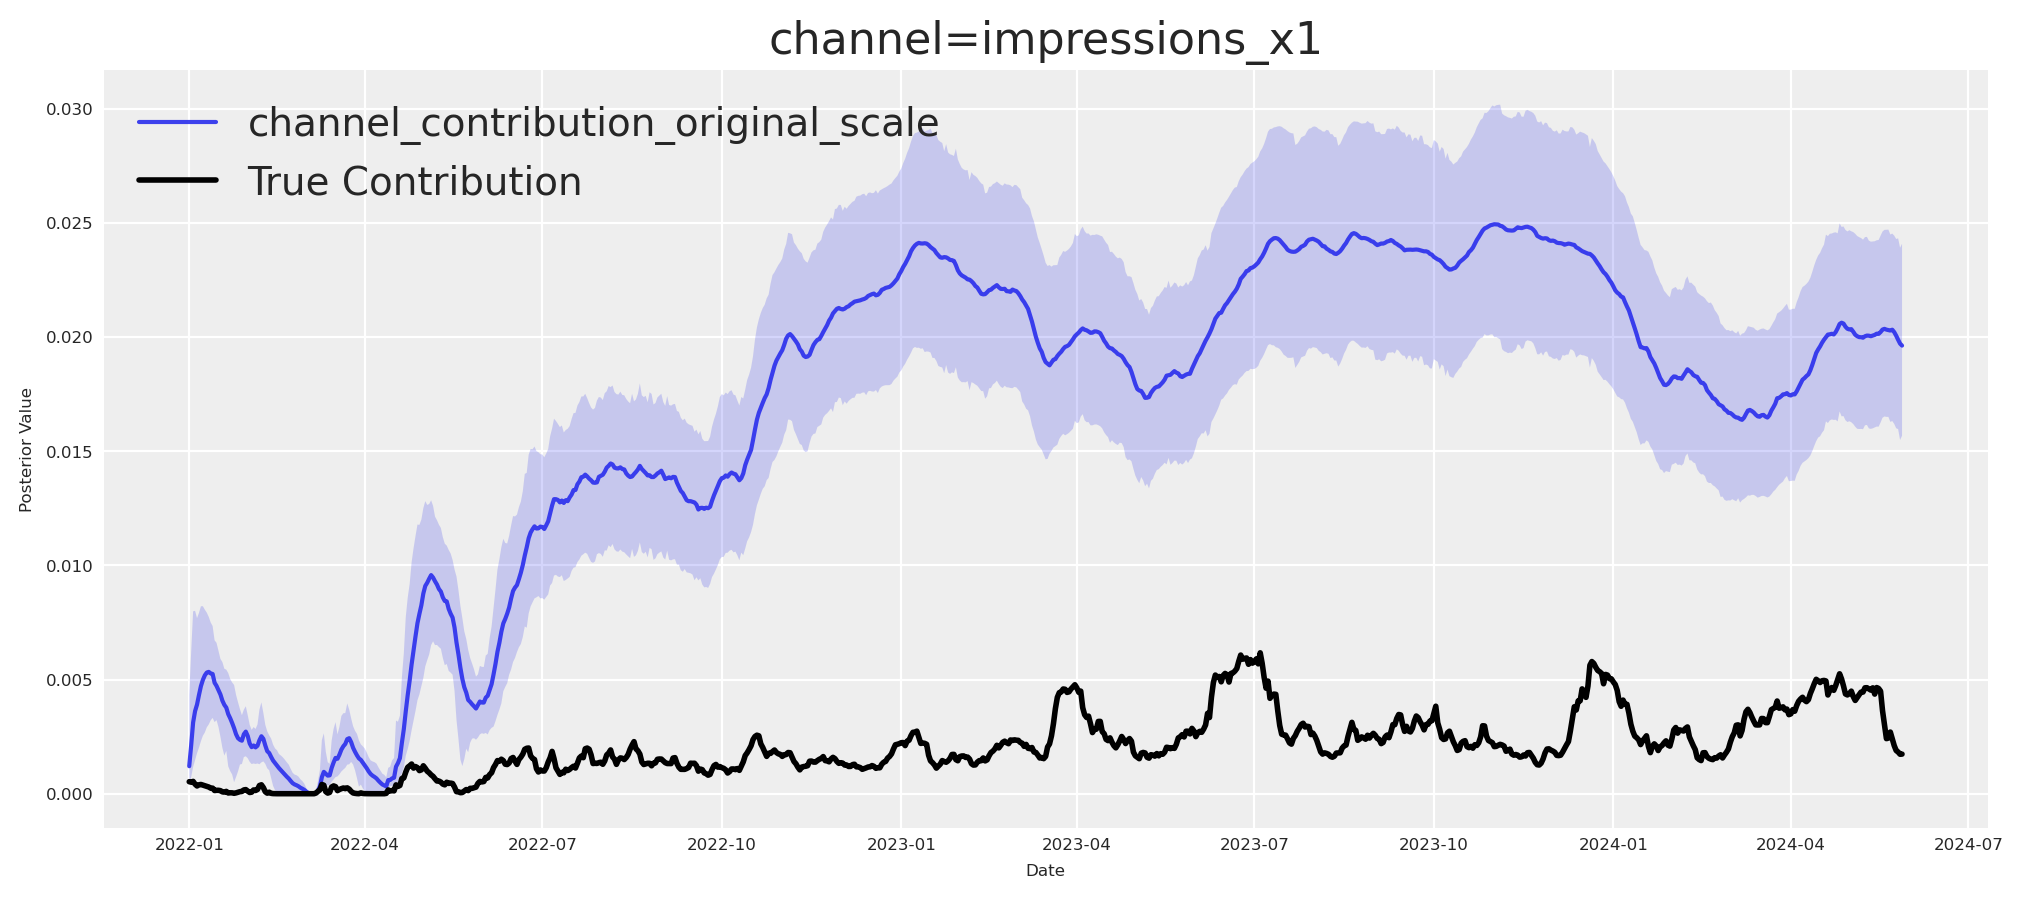

In [24]:
fig, ax = allin_mmm.plot.contributions_over_time(
    var=["channel_contribution_original_scale"], hdi_prob=0.95
)  # subplot 1 col, N rows = len(channel_columns)
# Keep only the first subplot (row 0, col 0) and hide the rest
for i in range(1, len(ax)):
    ax[i, 0].set_visible(False)
# pick only the first row don't plot the rest
ax[0, 0].plot(
    date_range[:train_idx],
    x1_real_contribution[:train_idx],
    label="True Contribution",
    color="black",
    linewidth=2,
)
ax[0, 0].legend()
plt.show()

As expected, put-it-all-in-the blender overestimates the upper funnel effects.

Maybe, we can just try to make a simple regression using $X1$ to uncover the real effect over target?

In [25]:
simple_mmm = MMM(
    date_column="date",
    target_column="target_var",
    channel_columns=["impressions_x1"],
    control_columns=control_columns,
    adstock=adstock,
    saturation=saturation,
    model_config=model_config,
    sampler_config=sample_kwargs,
)
simple_mmm.build_model(X_train, y_train)
simple_mmm.add_original_scale_contribution_variable(var=["channel_contribution", "y"])

simple_mmm.fit(
    X_train,
    y_train,
)
simple_mmm.sample_posterior_predictive(X_train, extend_idata=True, combined=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_alpha, saturation_lam, gamma_control, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 26 seconds.


Output()

Sampling: [y]


Output()

<xarray.Dataset> Size: 28MB
Dimensions:           (date: 879, sample: 2000)
Coordinates:
  * date              (date) datetime64[ns] 7kB 2022-01-01 ... 2024-05-28
  * sample            (sample) object 16kB MultiIndex
  * chain             (sample) int64 16kB 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * draw              (sample) int64 16kB 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables:
    y                 (date, sample) float64 14MB 0.4706 0.478 ... 0.8469 0.8098
    y_original_scale  (date, sample) float64 14MB 0.4792 0.4867 ... 0.8245
Attributes:
    created_at:                 2025-10-03T13:34:50.773217+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

Let's check the estimated contribution for X1 over the target.

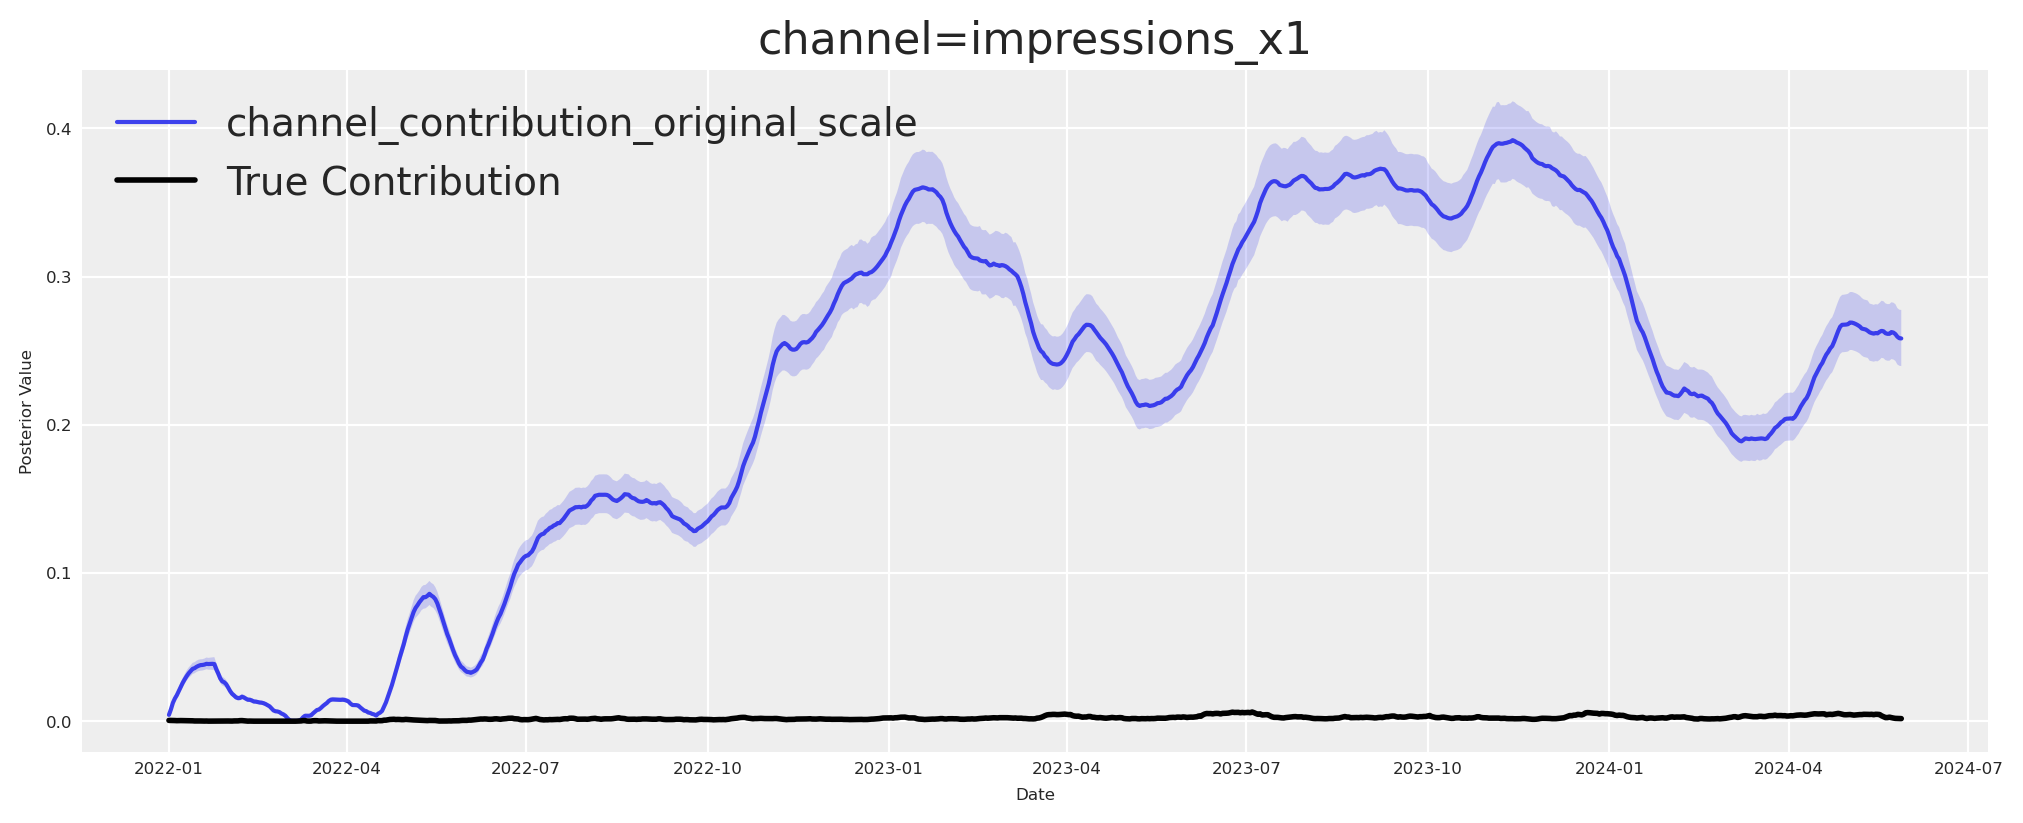

In [26]:
fig, ax = simple_mmm.plot.contributions_over_time(
    var=["channel_contribution_original_scale"], hdi_prob=0.95
)  # subplot 1 col, N rows = len(channel_columns)
# Keep only the first subplot (row 0, col 0) and hide the rest
for i in range(1, len(ax)):
    ax[i, 0].set_visible(False)
ax[0, 0].plot(
    date_range[:train_idx],
    x1_real_contribution[:train_idx],
    label="True Contribution",
    color="black",
    linewidth=2,
)
ax[0, 0].legend()
plt.show()

We hit again another wall. The contributions recovery by the last two models are not matching. Do we have any other way or alternative? - The answer is yes, and causality is at the center of it.

How to do this in a causal way? We need to understand our ecosystem and how the causal relationships work. In this case, this will imply to estimate the effect of $X4$ on $Y$. Then we could estimate the effect of $X1$ on $X4$ and get the propagation of the effect of $X1$ on $Y$ after.

But why? let's see the theory behind it.

### Mediator model

$X1$ is the upper funnel channel. $X4$ is the lower funnel channel. $Y$ is the outcome. This means that $X1$ does not have a direct effect on $Y$, but it does have an indirect effect through $X4$. This means, $X4$ mediates the effect of $X1$ on $Y$.

The minimal adjustment set based on backdoor paths dictates that we need to estimate the effect of $X4$ on $Y$ easily, a simple linear or nonlinear model would be enough. $Y ~ f(\theta, X4) + \epsilon$ because $X4$ will block all backdoor paths for the rest of variables.

In [27]:
first_causal_mmm = MMM(
    date_column="date",
    target_column="target_var",
    channel_columns=["impressions_x4"],
    control_columns=control_columns,
    adstock=adstock,
    saturation=saturation,
    model_config=model_config,
    sampler_config=sample_kwargs,
)
first_causal_mmm.build_model(X_train, y_train)
first_causal_mmm.add_original_scale_contribution_variable(
    var=["channel_contribution", "y"]
)

first_causal_mmm.fit(
    X_train,
    y_train,
)
first_causal_mmm.sample_posterior_predictive(X_train, extend_idata=True, combined=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_alpha, saturation_lam, gamma_control, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 16 seconds.


Output()

Sampling: [y]


Output()

<xarray.Dataset> Size: 28MB
Dimensions:           (date: 879, sample: 2000)
Coordinates:
  * date              (date) datetime64[ns] 7kB 2022-01-01 ... 2024-05-28
  * sample            (sample) object 16kB MultiIndex
  * chain             (sample) int64 16kB 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * draw              (sample) int64 16kB 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables:
    y                 (date, sample) float64 14MB 0.4962 0.5039 ... 0.882 0.8674
    y_original_scale  (date, sample) float64 14MB 0.5052 0.513 ... 0.8981 0.8832
Attributes:
    created_at:                 2025-10-03T13:35:08.720562+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

We are model read, lets see if we can recover the true contribution of $X4$ on $Y$. This will be the most essential step to recover the true contribution of $X1$ on $Y$ after. Again, we can take our pytensor graph and evaluate it with the values of $X4$ and get the true contribution.

In [28]:
real_contribution_x4 = (
    impressions_x4_forward.eval(
        {
            "impressions_x1": impressions_x1_var,
            "event_signal": np_event_signal[:-1],
            "beta_event_x1": beta_event_x1_var,
            "impressions_x2": impressions_x2_var,
            "impressions_x3": impressions_x3_var,
            "impressions_x4": impressions_x4_var,
            "beta_x1_x2": beta_x1_x2_var,
            "beta_x1_x3": beta_x1_x3_var,
            "beta_x2_x4": beta_x2_x4_var,
            "beta_x3_x4": beta_x3_x4_var,
            "x4_adstock_alpha": x4_adstock_alpha,
            "x4_sat_lam": x4_sat_lam,
            "x4_sat_alpha": x4_sat_alpha,
        }
    )
    * scaler_factor_for_target
)

If this outcome block is faithful, its contributions should trace the simulated truth.

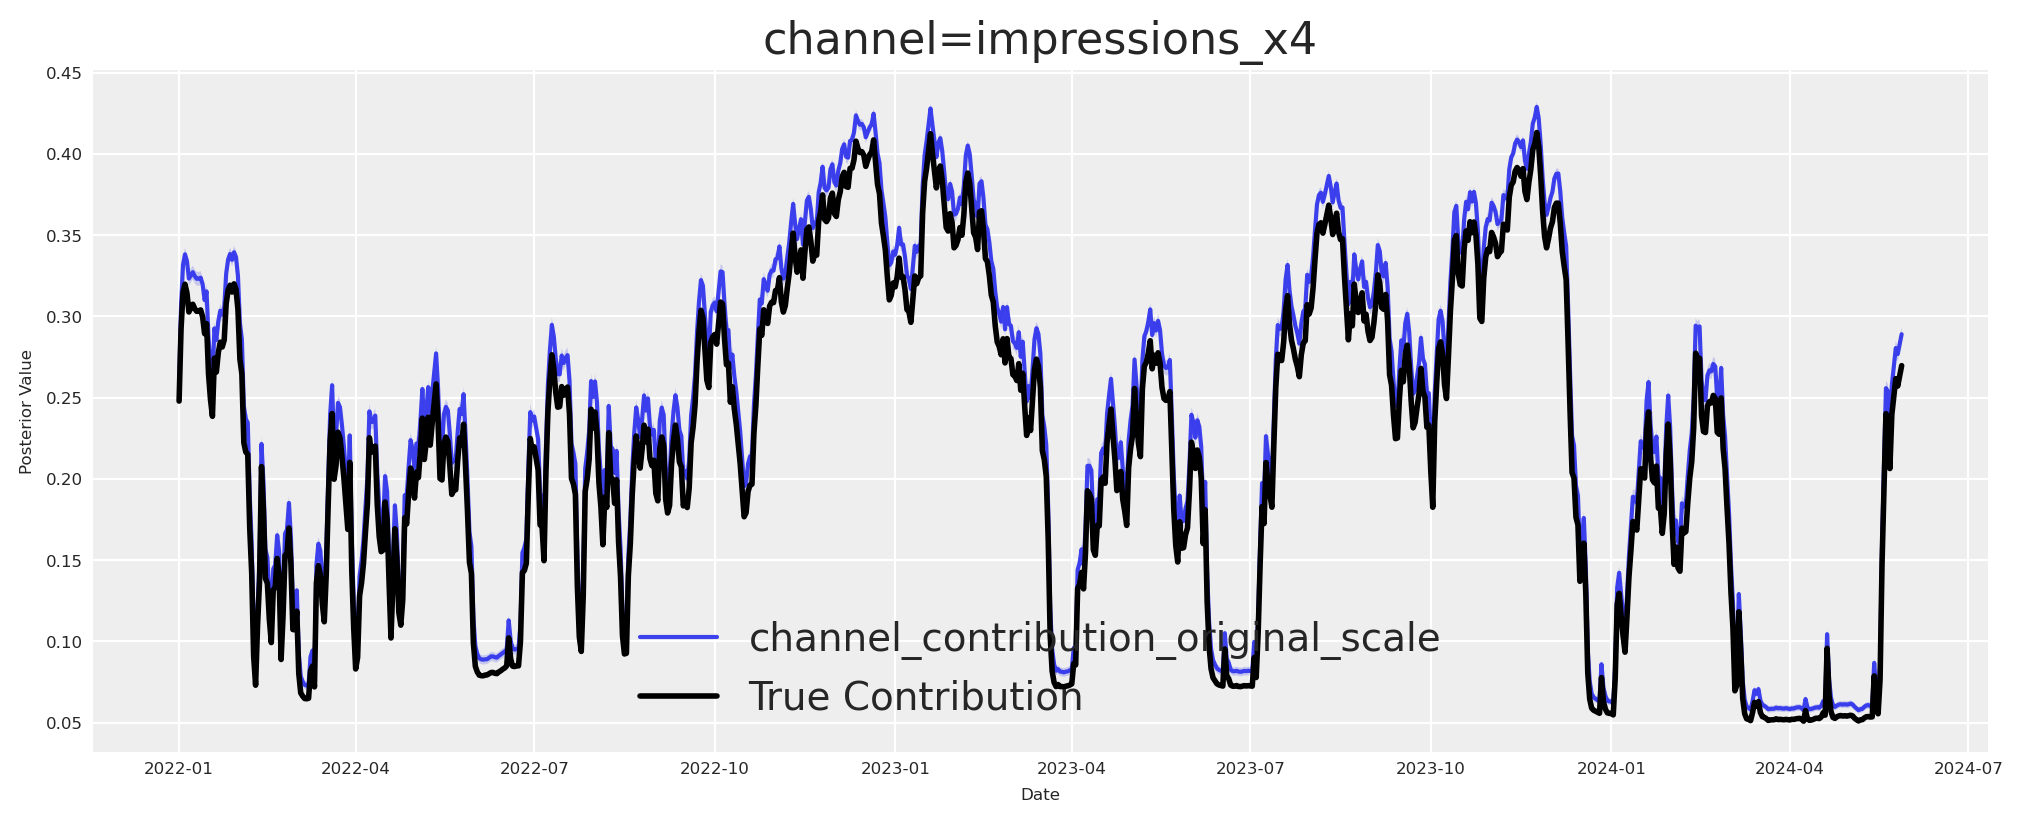

In [29]:
fig, ax = first_causal_mmm.plot.contributions_over_time(
    var=["channel_contribution_original_scale"], hdi_prob=0.95
)  # subplot 1 col, N rows = len(channel_columns) = 1
ax[0, 0].plot(
    date_range[:train_idx],
    real_contribution_x4[:train_idx],
    label="True Contribution",
    color="black",
    linewidth=2,
)
ax[0, 0].legend()
plt.show()

Great, we can observe that the true value was recovered. Now I estimate the effect of $(X_1)$ on $(X_4)$. This is the second essential step before quantifying the contribution of $(X_1)$ to $(Y)$.

**Modeling choices.**  
1) I temporarily remove adstock and saturation so the $(X_1 \to X_4)$ relation is linear.  
2) I avoid a levels-on-levels regression like $(X_{4,t} = \beta\,X_{1,t} + \varepsilon_t)$.

**Why differences.**  
If $(X_{1,t})$ and $(X_{4,t})$ are $(I(1))$ and *not* cointegrated, the residual from $(X_{4,t} - \beta X_{1,t})$ remains $(I(1))$. OLS in levels yields invalid inference and a drifting $(\hat\beta)$. First-differencing removes unit roots and yields a stationary relation:
$$
\Delta X_{4,t} = \alpha + \beta\,\Delta X_{1,t} + \eta_t,
$$
where $(\eta_t)$ is $(I(0))$. Under standard exogeneity of innovations, OLS consistently estimates the **total instantaneous effect** $(\beta)$ of $(X_1)$ on $(X_4)$.

> In practice, $\alpha \neq 0$ because drifts in the level processes translate into a nonzero mean in differences.

Let's build this model to see if we can recover the true value.

In [30]:
X_train["impressions_x1_diff"] = X_train["impressions_x1"].diff()
X_train["impressions_x4_diff"] = X_train["impressions_x4"].diff()

second_causal_mmm = MMM(
    date_column="date",
    target_column="impressions_x4_diff",
    channel_columns=["impressions_x1_diff"],
    adstock=NoAdstock(
        l_max=1
    ),  # We remove the adstock because we want to estimate the causal effect of x1 on x4 which is purely linear
    saturation=NoSaturation(
        priors={"beta": Prior("Gamma", mu=0.7, sigma=0.4)}
    ),  # linear beta
    sampler_config=sample_kwargs,
)
second_causal_mmm.build_model(
    X_train.drop(columns=["impressions_x4_diff"]),
    X_train["impressions_x4_diff"],
)
second_causal_mmm.add_original_scale_contribution_variable(
    var=["channel_contribution", "y"]
)
second_causal_mmm.fit(
    X_train.drop(columns=["impressions_x4_diff"]),
    X_train["impressions_x4_diff"],
)
second_causal_mmm.sample_posterior_predictive(
    X_train.drop(columns=["impressions_x4_diff"]),
    extend_idata=True,
    combined=True,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, saturation_beta, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Output()

Sampling: [y]


Output()

<xarray.Dataset> Size: 28MB
Dimensions:           (date: 879, sample: 2000)
Coordinates:
  * date              (date) datetime64[ns] 7kB 2022-01-01 ... 2024-05-28
  * sample            (sample) object 16kB MultiIndex
  * chain             (sample) int64 16kB 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * draw              (sample) int64 16kB 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables:
    y                 (date, sample) float64 14MB 0.2204 0.1342 ... -0.08171
    y_original_scale  (date, sample) float64 14MB 0.009457 ... -0.003505
Attributes:
    created_at:                 2025-10-03T13:35:10.598036+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

We can plot the posterior distribution of the beta to see if the true value was recovered.

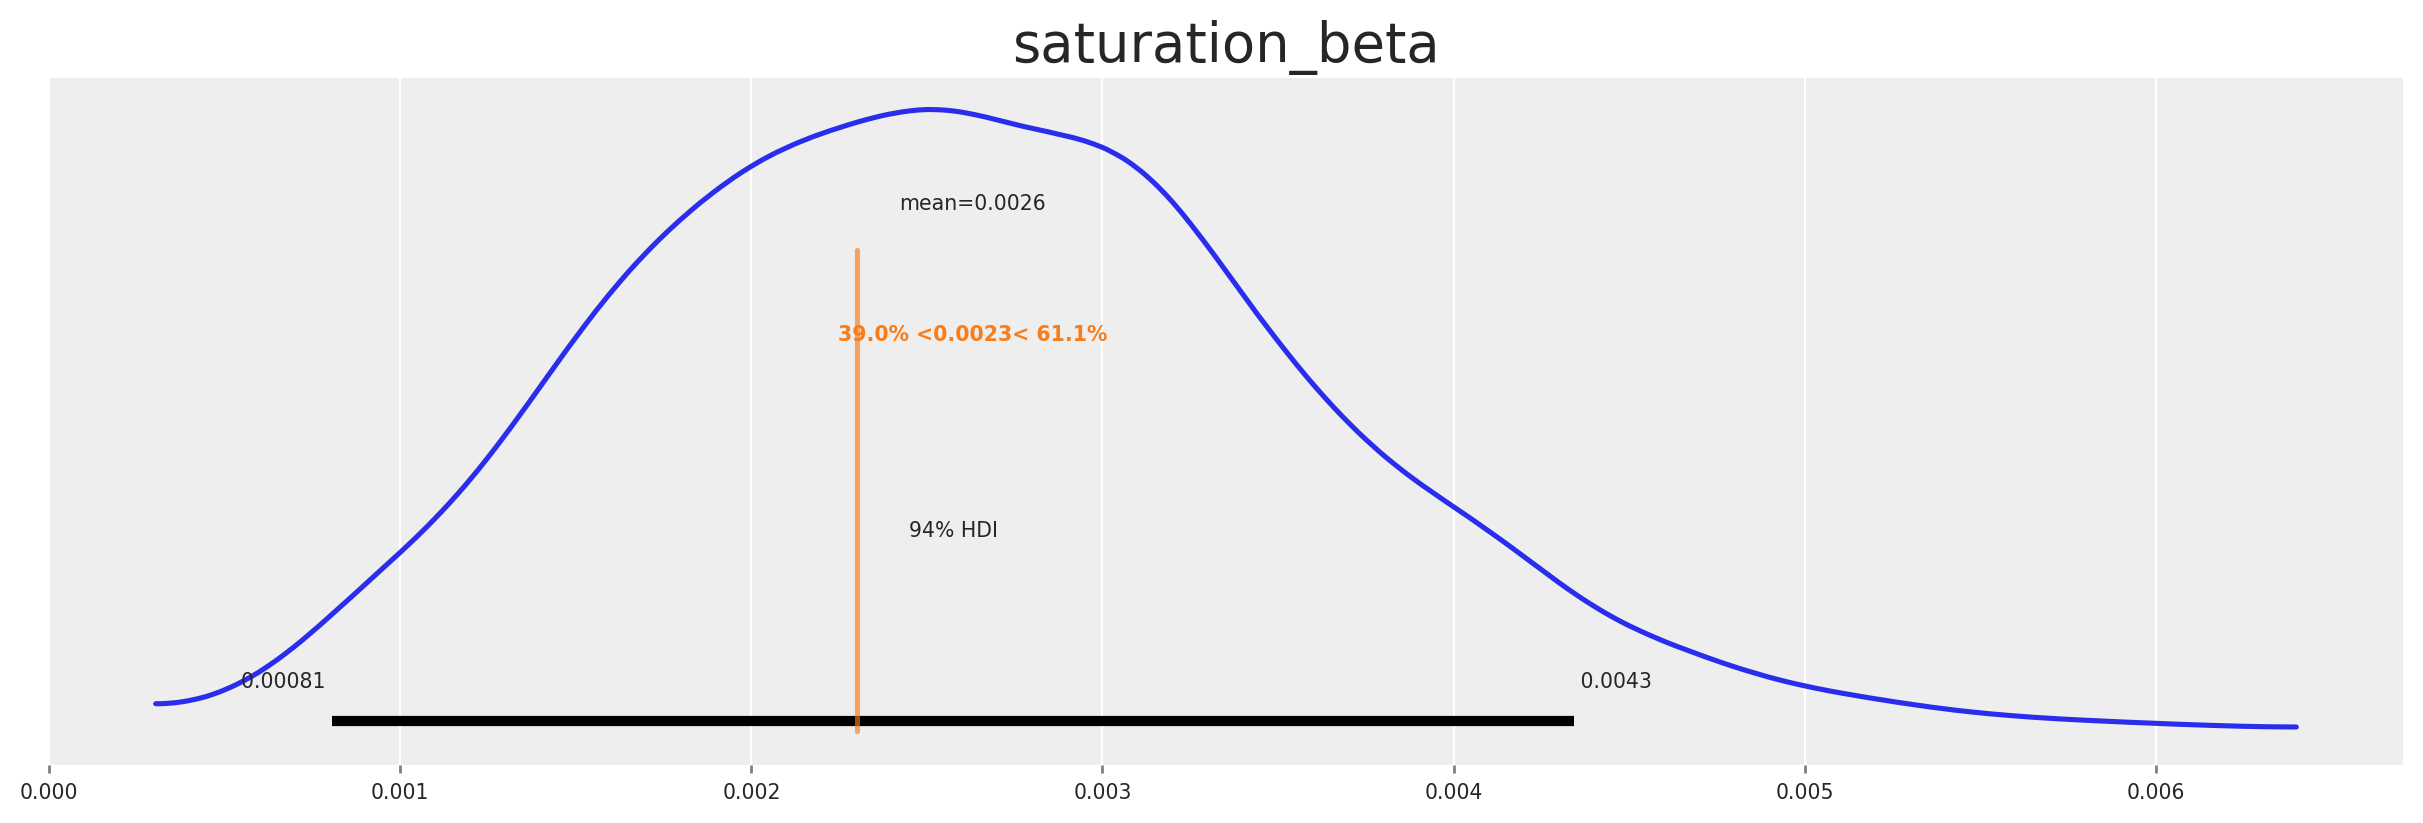

In [31]:
az.plot_posterior(
    second_causal_mmm.fit_result * second_causal_mmm.scalers._target.item(),
    var_names=[
        "saturation_beta",
    ],
    figsize=(12, 4),
    ref_val=(beta_x1_x2_var * beta_x2_x4_var + beta_x1_x3_var * beta_x3_x4_var)
    * scaler_factor_for_impressions,
);

The posterior settles near the ground truth—which is what we’d hope if our story is coherent. Now, what? Armed with the mediated beta, we translate awareness into downstream pressure over time, in‑sample and beyond.

Let's create the xarray with proper broadcasting for chain, draw, date dimensions.

In [32]:
# Create xarray with proper broadcasting for chain, draw, date dimensions
impressions_x1_values = X_train["impressions_x1"].values  # shape: (date,)
saturation_beta_scaled = (
    second_causal_mmm.idata.posterior.saturation_beta
    * second_causal_mmm.scalers._target.item()
)  # shape: (chain, draw)

# Broadcast to create (chain, draw, date) output
posterior_result = (
    impressions_x1_values[None, None, :] * saturation_beta_scaled.values[:, :, None]
)

posterior_contribution_x1_over_x4 = xr.DataArray(
    posterior_result,
    dims=["chain", "draw", "date"],
    coords={
        "chain": second_causal_mmm.idata.posterior.chain,
        "draw": second_causal_mmm.idata.posterior.draw,
        "date": X_train.index,
    },
)

Now, we got the estimated contribution of $X1$ on $X4$. Let's plot against the true contribution of $X1$ on $X4$.

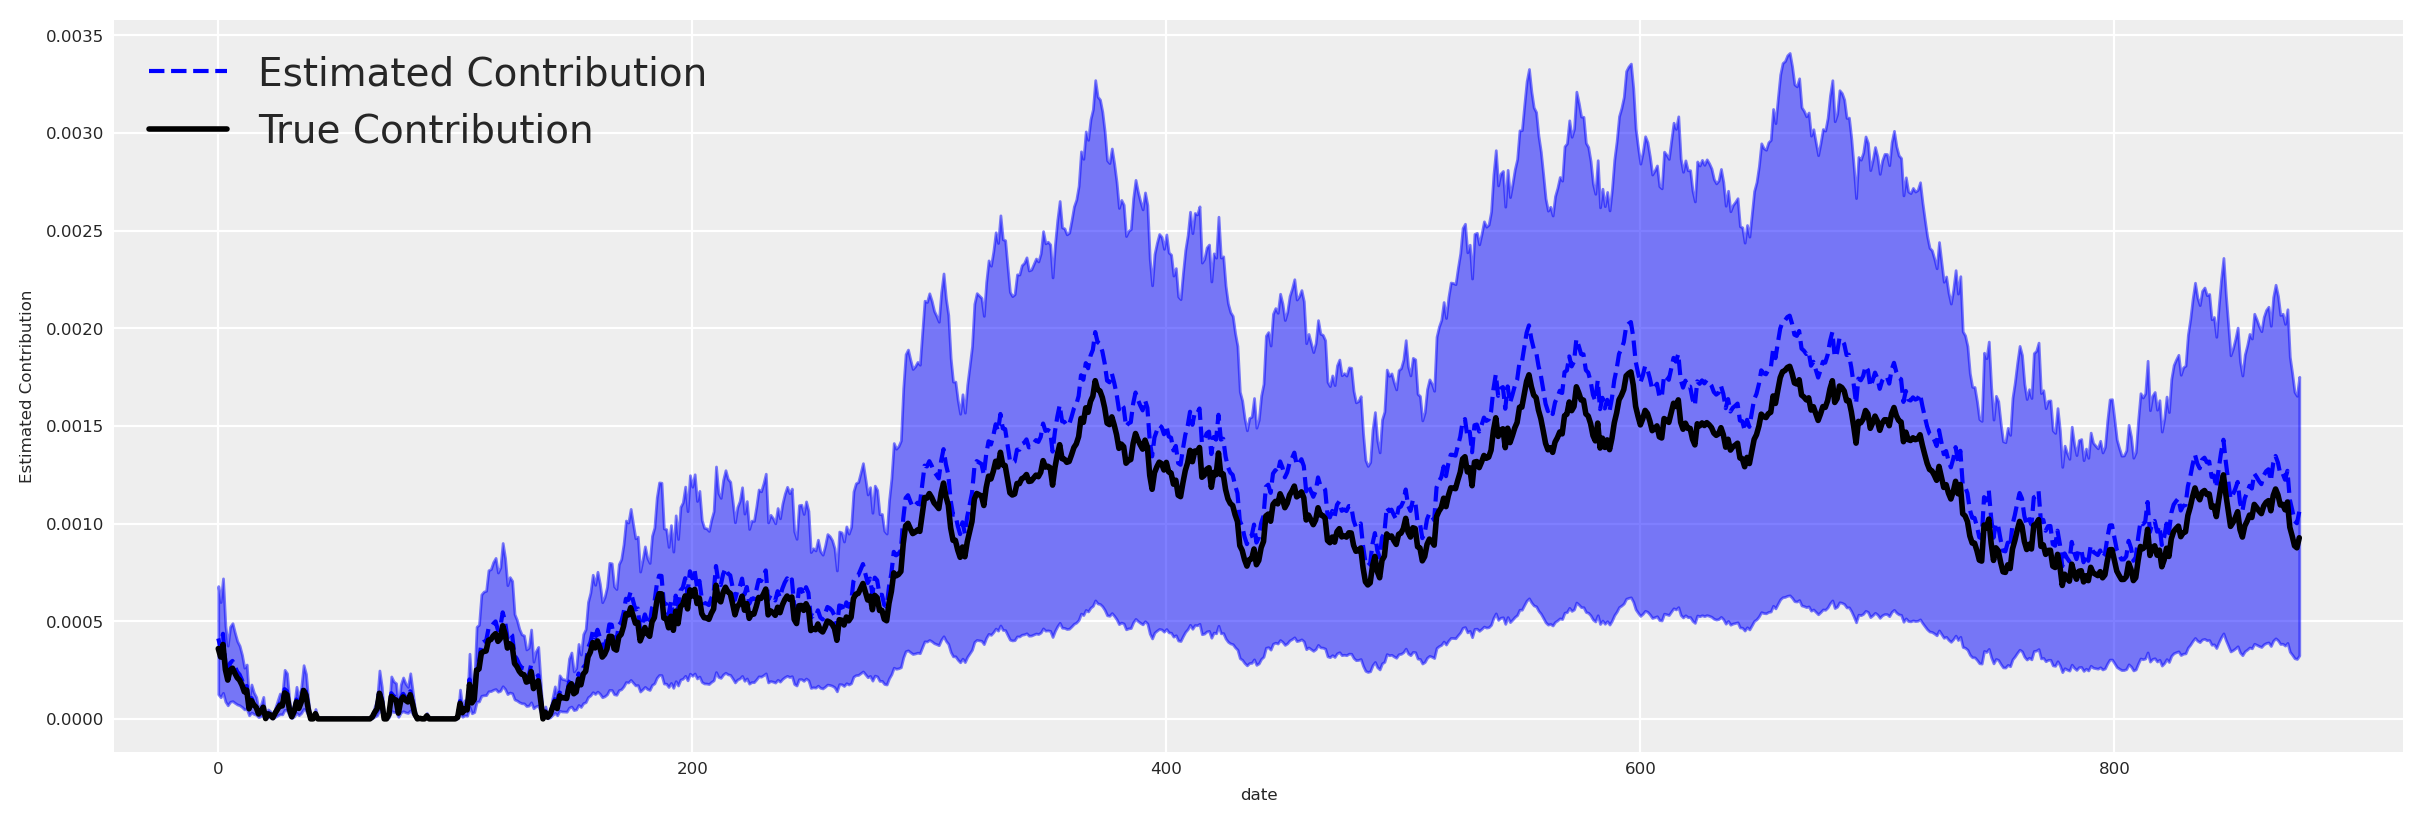

In [33]:
# Get HDI for the posterior contribution
hdi_data = az.hdi(posterior_contribution_x1_over_x4, hdi_prob=0.94)

# Plot HDI and mean in the same plot
fig, ax = plt.subplots(figsize=(12, 4))

# Plot HDI
az.plot_hdi(
    X_train.index,
    posterior_contribution_x1_over_x4.values,
    ax=ax,
    color="blue",
    smooth=False,
)

# Plot mean
posterior_contribution_x1_over_x4.mean(dim=["draw", "chain"]).plot(
    ax=ax, label="Estimated Contribution", color="blue", linestyle="--"
)

# Plot true contribution
ax.plot(
    X_train.index,
    (
        (impressions_x1_values * scaler_factor_for_impressions)
        * (beta_x1_x2_var * beta_x2_x4_var + beta_x1_x3_var * beta_x3_x4_var)
    ),
    label="True Contribution",
    color="black",
    linewidth=2,
)

ax.set_ylabel("Estimated Contribution")
ax.legend()
plt.show()

Great, we can see that the estimated contribution is very close to the true contribution in the in-sample period. We can do the same for the out-of-sample period, and using the out of sample period, we can check if we recovered the causal effect of $X1$ on $Y$.

In [34]:
oos_impressions_x1_values = X_test["impressions_x1"].values  # shape: (date,)

# Broadcast to create (chain, draw, date) output
oos_posterior_result = (
    oos_impressions_x1_values[None, None, :] * saturation_beta_scaled.values[:, :, None]
)

oos_posterior_contribution_x1_over_x4 = xr.DataArray(
    oos_posterior_result,
    dims=["chain", "draw", "date"],
    coords={
        "chain": second_causal_mmm.idata.posterior.chain,
        "draw": second_causal_mmm.idata.posterior.draw,
        "date": X_test.index,
    },
)

This estimations tell us how much $X1$ is contributing to $X4$ in the out-of-sample period. If we want to ask the causal question, we need a counterfactual: What would $X4$ have been if awareness had gone to zero? We can do this by taking the original value of $X4$ and subtracting the estimated contribution of $X1$ on $X4$.

In [35]:
oos_x4_counterfactual = (
    (impressions_x4_eval * scaler_factor_for_impressions)[train_idx:][
        None, None, :
    ]  # we need impressions_x4_eval to be in the same scale as the model
    - oos_posterior_contribution_x1_over_x4
)

We send that counterfactual $X_4$ under $do(X_1=0)$ through the outcome model to obtain $Y$ under $do(X_1=0)$ as consequence. Then the causal effect will be $Y|do(X_1=1) - Y|do(X_1=0)$.

We'll compute the true influence of $X_1$ on $Y$ by our true pytensor graph, and finally, we'll compare the recovered effect with the true effect.

In [36]:
X_test_x1_zero = X_test.copy()
X_test_x1_zero["impressions_x4"] = oos_x4_counterfactual.median(
    dim=["draw", "chain"]
).values

y_do_x1_zero = first_causal_mmm.sample_posterior_predictive(
    X_test_x1_zero,
    extend_idata=False,
    include_last_observations=True,
    combined=False,
    random_seed=SEED,
    var_names=["channel_contribution_original_scale", "y_original_scale"],
)

y_do_x1 = first_causal_mmm.sample_posterior_predictive(
    X_test,
    extend_idata=False,
    include_last_observations=True,
    combined=False,
    random_seed=SEED,
    var_names=["channel_contribution_original_scale", "y_original_scale"],
)

# Estimated effect of x1 in Y
x1_causal_effect = (y_do_x1_zero - y_do_x1).channel_contribution_original_scale.sum(
    dim="channel"
)

# Estimate real effect of x1 in Y
impressions_x1_var_intervention = impressions_x1_var.copy()
impressions_x1_var_intervention[train_idx:] = 0

# Eval target_var and plot
target_var_x1_intervention_eval = y.eval(
    {
        "impressions_x1": impressions_x1_var_intervention,
        "event_signal": np_event_signal[:-1],
        "beta_event_x1": beta_event_x1_var,
        "impressions_x2": impressions_x2_var,
        "impressions_x3": impressions_x3_var,
        "impressions_x4": impressions_x4_var,
        "beta_x1_x2": beta_x1_x2_var,
        "beta_x1_x3": beta_x1_x3_var,
        "beta_x2_x4": beta_x2_x4_var,
        "beta_x3_x4": beta_x3_x4_var,
        "x4_adstock_alpha": x4_adstock_alpha,
        "x4_sat_lam": x4_sat_lam,
        "x4_sat_alpha": x4_sat_alpha,
        "event_contributions": np_event_contributions[:-1],
        "trend": np_trend,
        "global_noise": pz_global_noise,
    }
)

causal_effect_x1_over_y = (
    target_var_x1_intervention_eval - target_var_eval
) * scaler_factor_for_target

Sampling: [y]


Output()

Sampling: [y]


Output()

Let's plot the recovered effect against the true effect, side‑by‑side.

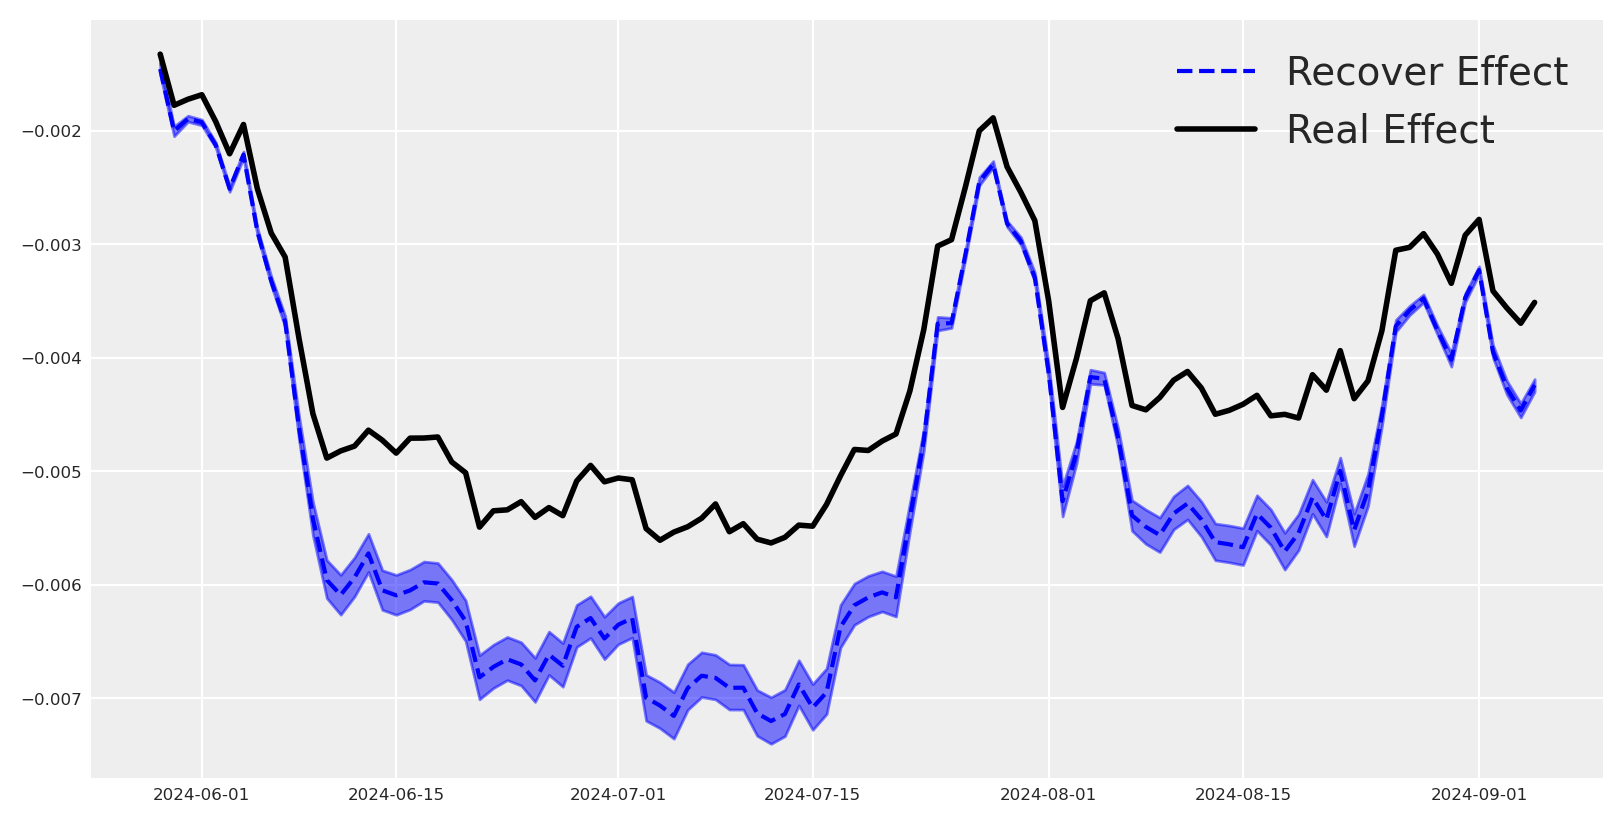

In [37]:
dates = x1_causal_effect.coords["date"].values[:100]  # Take only first 100 days
mean_effect = (
    x1_causal_effect.mean(dim=["draw", "chain"])
    .sel(date=slice(dates[0], dates[-1]))
    .values
)
plt.plot(dates, mean_effect, label="Recover Effect", color="blue", linestyle="--")
plt.plot(
    dates,
    causal_effect_x1_over_y[train_idx:][:100],
    label="Real Effect",
    color="black",
    linewidth=2,
)
az.plot_hdi(
    dates,
    x1_causal_effect.sel(date=slice(dates[0], dates[-1])),
    color="blue",
    smooth=False,
)
plt.legend()

This is great, we can see that the recovered effect is very close to the true effect in the in-sample period. We can do the same for the out-of-sample period, and using the out of sample period, we observe the causal effect of $X1$ on $Y$ was properly recovered.

## Conclusion

In this tutorial we showed that it is possible to recover high‑level, upper‑funnel impacts even when the observed target is a lower‑funnel KPI. By explicitly modeling mediation and then propagating that signal through the outcome model, we captured the causal contribution of upper‑funnel activity from low‑level targets.

- **Estimate mediated effect**: quantify the link from awareness to a downstream mediator and recover its contribution.
- **Propagate to outcomes**: translate the mediated effect into expected pressure on the final target via the MMM.
- **Causal counterfactuals**: compare against do‑operator counterfactuals to measure upper‑funnel lift credibly.

This makes upper‑funnel value measurable alongside performance channels, improving attribution, forecasting, and budget decisions while keeping the model grounded in causal structure.

In [38]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,pymc,pymc_marketing,numpyro

Last updated: Fri Oct 03 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pytensor      : 2.31.7
pymc          : 5.25.1
pymc_marketing: 0.16.0
numpyro       : 0.19.0

graphviz      : 0.21
arviz         : 0.22.0
pytensor      : 2.31.7
pymc_extras   : 0.4.0
pandas        : 2.3.1
matplotlib    : 3.10.3
xarray        : 2025.7.1
pymc_marketing: 0.16.0
numpy         : 2.2.6
preliz        : 0.20.0

Watermark: 2.5.0

